# Imports

In [19]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

#device = 0
#torch.cuda.set_device(device)

%reload_ext autoreload
%autoreload 2
#%matplotlib notebook
%matplotlib inline
from bokeh.io import output_notebook


import sys

#https://github.com/FAU-DLM/python-wsi-preprocessing
sys.path.append('../preprocessing_pipeline/python-wsi-preprocessing/')
import wsi
from wsi import tiles, util

sys.path.append('../fastai/')
import fastai
from fastai.vision import *
from fastai.vision.learner import model_meta
from fastai.callbacks import *

sys.path.append('../models-pytorch/pretrained-models.pytorch')
import pretrainedmodels
from pretrainedmodels import *

from typing import Dict
import pandas as pd
import numpy as np
import os
import torch
import torchvision
from torchvision.models import *
from torchsummary import summary
from pathlib import Path
from functools import partial, update_wrapper
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import shutil
from sklearn.model_selection import StratifiedKFold, KFold
from typing import List, Callable
from PIL import Image
Image.MAX_IMAGE_PIXELS = 10000000000   

PATH = Path('/home/Deep_Learner/private/network/datasets/Hypophysenadenome/')
PATH_LOCAL = Path('/home/Deep_Learner/private/local/')
FONT_PATH=PATH/'1984-Happines-Regular.ttf'

WSIS_CORTICOTROP = PATH/'corticotrop'
WSIS_GONADOTROP = PATH/'gonadotrop'

ROIS_CORTICOTROP = PATH/'corticotrop_ROIs'
ROIS_GONADOTROP = PATH/'gonadotrop_ROIs'

TILES_CORTICOTROP_1 = PATH/'tiles_corticotrop_1_scoring_function_1_thresh_0.55'
TILES_CORTICOTROP_2 = PATH/'tiles_corticotrop_2_scoring_function_1_thresh_0.55'
TILES_CORTICOTROP_3 = PATH/'tiles_corticotrop_3_scoring_function_1_thresh_0.4'

TILES_GONADOTROP_1 = PATH/'tiles_gonadotrop_1_scoring_function_1_thresh_0.55'
TILES_GONADOTROP_2 = PATH/'tiles_gonadotrop_2_scoring_function_1_thresh_0.55'
TILES_GONADOTROP_3 = PATH/'tiles_gonadotrop_3_scoring_function_1_thresh_0.4'

#TEST = PATH/TEST_NAME
#TEST = PATH_LOCAL/TEST_NAME
TEST_EXPERIMENTING = PATH_LOCAL/'tiles_test_100_for_testing'
LABELS_CORTICOTROP_NAME = 'KortikotropHA_gelabled.xlsx'
LABELS_CORTICOTROP = PATH/LABELS_CORTICOTROP_NAME
LABELS_GONADOTROP_NAME = 'GonadotropeHA_gelabled.xlsx'
LABELS_GONADOTROP = PATH/LABELS_GONADOTROP_NAME
MODEL_PATH_NAME = 'models'
MODEL_PATH = PATH/MODEL_PATH_NAME

ROIS_EXPERIMENTING = PATH/'rois_experimenting'
TILES_EXPERIMENTING = PATH/'tiles_experimenting'

torch.backends.cudnn.benchmark=True

#def batch_stats(self, funcs:Collection[Callable]=None)->Tensor:
#        "Grab a batch of data and call reduction function `func` per channel"
#        funcs = ifnone(funcs, [torch.mean,torch.std])
#        x = self.one_batch(ds_type=DatasetType.Train, denorm=False)[0].cpu()
#        return [func(channel_view(x), 1) for func in funcs]
#        
#vision.data.ImageDataBunch.batch_stats = batch_stats

sz = 512
bs = 6

#fastai defaults
tta_beta = 0.4 
tta_scale = 1.35
dropout = 0.5
wd = 0.01

#non defaults
#wd = 0.1 not better for se_resnext50
#dropout = 0.9


seed = 19
np.random.seed(seed)

num2lbs = {
    0:"corticotrop", 
    3:"silent",  
    8:"LH", 
    9:"FSH"
}

lbs2num = {l:n for n,l in num2lbs.items()}

# Utils

In [8]:
from fastai.torch_core import flatten_model

def arch_summary(arch):
    model = arch(False)
    tot = 0
    for i, l in enumerate(model.children()):
        n_layers = len(flatten_model(l))
        tot += n_layers
        print(f'({i}) {l.__class__.__name__:<12}: {n_layers:<4}layers (total: {tot})')

def show(np):
    return util.np_to_pil(np)

Path.ls = lambda x: [p for p in list(x.iterdir()) if '.ipynb_checkpoints' not in p.name]

def show_multiple_images(path, rows = 3, figsize=(128, 64)):
    imgs = [open_image(p) for p in path.ls()]
    show_all(imgs=imgs, r=rows, figsize=figsize)
    
def show_multiple_images_big(path:pathlib.Path):
    for p in path.ls():
        plt.imshow(mpimg.imread(str(p)))
        plt.show()
        
def get_id_from_path(path):
    path = Path(path)
    split = path.stem.split('-')
    return f'{split[0]}-{split[1]}'

def get_slide_name_from_path(path):
    path = Path(path)
    split = path.stem.split('-')
    try:
        return f'{split[0]}-{split[1]}-{split[2]}-{split[3]}'
    except IndexError:
        return f'{split[0]}-{split[1]}-{split[2]}'

# Extra Models

In [9]:
#https://github.com/PPPW/deep-learning-random-explore/blob/master/CNN_archs/cnn_archs.ipynb

def identity(x): return x

def nasnetamobile(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.nasnetamobile(pretrained=pretrained, num_classes=1000)  
    model.logits = identity
    model_meta[nasnetamobile] =  { 'cut': identity, 'split': lambda m: (list(m[0][0].children())[8], m[1]) }
    return nn.Sequential(model)

#arch_summary(lambda _: nasnetamobile(False)[0])

def se_resnext50_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext50_32x4d(pretrained=pretrained)
    model_meta[se_resnext50_32x4d] =  {'cut': -2, 'split': lambda m: (m[0][3], m[1]) }
    return model

#arch_summary(lambda _: pretrainedmodels.se_resnext50_32x4d(pretrained=None))

def se_resnext101_32x4d(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.se_resnext101_32x4d(pretrained=pretrained)
    model_meta[se_resnext101_32x4d] =  {'cut': -2, 'split': lambda m: (m[0][3], m[1]) }
    return model

def xception(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.xception(pretrained=pretrained)
    model_meta[xception] =  { 'cut': -1, 'split': lambda m: (m[0][11], m[1]) }
    return model

def inceptionv4(pretrained=True):
    pretrained = 'imagenet' if pretrained else None
    model = pretrainedmodels.inceptionv4(pretrained=pretrained)
    model_meta[xception] =  { 'cut': -2, 'split': lambda m: (m[0][11], m[1]) }
    return model

# n 

In [10]:
#n='test'

n = np.load('n.npy')
print(n)

m = n+1
m=14
np.save('n', m)
print(m)

14
14


# Data 

## Some numbers of the dataset (not necessary for training)

### gonadotropic

In [ ]:
# all gonadotropic HE WSIs
wsi_names_gon = set([get_slide_name_from_path(p) for p in WSIS_GONADOTROP.ls() if ('HE' in str(p) and not ('LH' in str(p) or 'FSH' in str(p)))])
print(len(wsi_names_gon))

In [ ]:
# all gonadotropic cases == number of patients (one case per patient)
len(set([get_id_from_path(p) for p in WSIS_GONADOTROP.ls()]))

In [ ]:
# number of cases, ROIs have been extracted from
len(set([get_id_from_path(p) for p in ROIS_GONADOTROP.ls()]))

In [ ]:
tile_paths_gonadotrop_1 = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_GONADOTROP_1.ls()) if p.suffix == '.png']
tile_paths_gonadotrop_2 = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_GONADOTROP_2.ls()) if p.suffix == '.png']
tile_paths_gonadotrop_3 = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_GONADOTROP_3.ls()) if p.suffix == '.png']
tile_paths_all_gonadotrop = tile_paths_gonadotrop_1 \
                            + tile_paths_gonadotrop_2 \
                            + tile_paths_gonadotrop_3 

In [ ]:
# number of cases, tiles have been extracted from
len(set([get_id_from_path(p) for p in tile_paths_all_gonadotrop]))

In [ ]:
len(tile_paths_all_gonadotrop)

### corticotropic

In [ ]:
# all corticotropic HE WSIs
wsi_names_cort = set([get_slide_name_from_path(p) for p in WSIS_CORTICOTROP.ls() if ('HE' in str(p) and not 'ACTH' in str(p))])
print(len(wsi_names_cort))

In [ ]:
# all corticotropic cases == number of patients (one case per patient, but some cases have more than one HE WSI)
len(set([get_id_from_path(p) for p in WSIS_CORTICOTROP.ls()]))

In [ ]:
# number of cases, ROIs have been extracted from
len(set([get_id_from_path(p) for p in ROIS_CORTICOTROP.ls()]))

In [ ]:
tile_paths_corticotrop_1 = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_CORTICOTROP_1.ls()) if p.suffix == '.png']
tile_paths_corticotrop_2 = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_CORTICOTROP_2.ls()) if p.suffix == '.png']
tile_paths_corticotrop_3 = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_CORTICOTROP_3.ls()) if p.suffix == '.png']


tile_paths_all_corticotrop = tile_paths_corticotrop_1 \
                            + tile_paths_corticotrop_2 \
                            + tile_paths_corticotrop_3 \

In [ ]:
# number of cases, tiles have been extracted from
len(set([get_id_from_path(p) for p in tile_paths_all_corticotrop]))

In [ ]:
len(tile_paths_all_corticotrop)

## Create pandas dataframe with tile information to later extract tiles on the fly from WSIs during training (use this, if you do not have extracted tiles saved on disc)

In [11]:
tiles_df_path = PATH/'tiles_info-tile_score_thresh=0.4-tiles.scoring_function_1.csv'


if os.path.isfile(tiles_df_path):
    ###
    # just load from disc, if you have already calculated tile infos before
    ###
    tiles_df = pd.read_csv(tiles_df_path)
else:
    ###
    # generate and save tile info
    ###
    rois_paths_gonado = [p for p in ROIS_GONADOTROP.ls() if (p.suffix == '.png' and '-HE' in p.name)]
    rois_paths_cortico = [p for p in ROIS_GONADOTROP.ls() if (p.suffix == '.png' and '-HE' in p.name)]
    rois_paths_all = rois_paths_gonado + rois_paths_cortico
    tiles_df = tiles.WsiOrROIToTilesMultithreaded(wsiPaths=rois_paths_all, 
                                   tilesFolderPath=None, 
                                   tileHeight=1024, 
                                   tileWidth=1024, 
                                   tile_naming_func=tiles.get_roi_name_from_path_pituitary_adenoma_entities, 
                                   tile_score_thresh=0.4, 
                                   tileScoringFunction=tiles.scoring_function_1, 
                                   is_wsi=False, 
                                   level=0, 
                                   save_tiles=False)
    tiles_df.to_csv(tiles_df_path, index_label='tile_name')    

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_44-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_58-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_1-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_171-LH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_65-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_4-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_118-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_138-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_79-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_42-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 7/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1049-15-II-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2170-15-III-HE-ROI_21-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_21-L

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_30-FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_51-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_114-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_RO

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/299-12-III-HE-ROI_2-FSH.png: Number of tiles that will be saved/all possible tiles: 0/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_59-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_72-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/598-13-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_63-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_109-FSH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_39-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 51/77
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_10-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_8-LH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_49-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_95-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_95-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/1
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_74-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/96-16-HE-ROI_20-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_104-LH+F

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_81-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_58-LH.png: Number of tiles that will be saved/all possible tiles: 32/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_163-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_4-FSH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_72-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_28-FSH.png: Number of tiles that will be saved/all possible tiles: 19/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/441-16-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1006-12-IV-HE-ROI_1-LH.png: Number of tiles that will be saved/all possible tiles: 56/168
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_140-LH.png: Number of tiles that will be saved/all possible tiles: 2/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/64
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_12-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/840-13-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_40-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_21-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 27/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_30-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/21
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1759-13-III-HE-ROI_8-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/309-13-Z-HE-ROI_11-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_11-LH.png: Number of tiles that will be saved/all possible tiles: 6/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_93-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1759-13-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_148-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/578-14-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1561-15-III-HE-ROI_26-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_151-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_8-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_134-LH.png: Number of tiles that will be saved/all possible tiles: 0/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/307-15-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_1-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_1-LH.png: Number of tiles that will be saved/all possible tiles: 0/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/34-13-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 25/66
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/663-15-Z-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_31-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/42
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_30-LH+FSH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_31-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/852-14-III-HE-ROI_13-FSH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_20-FSH.png: Number of tiles that will be saved/all possible tiles: 5/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_59-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2191-14-I

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1046-15-III-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2170-15-III-HE-ROI_7-LH.png: Number of tiles that will be saved/all possible tiles: 1/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/840-13-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/288-15-Z-HE-ROI_15-LH.png: Number of tiles that will be saved/all possible tiles: 41/80
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/586-16-III-HE-ROI_12-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_26-LH.png: 

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_34-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/441-16-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_14-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 68/169
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_32-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_108-FSH.png: Number of tiles that will be saved/all possible tiles: 22/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/12

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_25-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_54-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 27/32
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_32-FSH.png: Number of tiles that will be saved/all possible tiles: 3/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_87-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_41-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 29/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_51-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 62/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2230-15-III2-HE-ROI_15-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1062-15-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_47-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_6-FSH.png: Number of tiles that will be saved/all possible tiles: 63/98
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_20-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_142-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_13-LH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/21

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/21
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_55-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_32-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_36-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_60-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 23/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_109-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_3-LH.png: Number of tiles that will be saved/all possible tiles: 12/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_91-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_63-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_21-LH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-II

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/507-13-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_3-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_30-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/961-14-I

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_110-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_23-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_7-FSH.png: Number of tiles that will be saved/all possible tiles: 15/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-II

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_51-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1062-15-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_19-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_58-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 134/168
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/13

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/718-12-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_43-FSH.png: Number of tiles that will be saved/all possible tiles: 14/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_26-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_110-LH.png: Number of tiles that will be saved/all possible tiles: 45/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_32-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_12-LH.p

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_57-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_109-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/425-15-II-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_43-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_32-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_93-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_101-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_31-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2134-15-III-HE-ROI_5-LH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_63-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_135-LH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_30-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_12-LH.png: Number of tiles that will be saved/all possible tiles: 12/20
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_53-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/678-12-III-HE-ROI_2-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_159-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-RO

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_26-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_145-LH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1064-15-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 91/132
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_52-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_54-LH.png: Number of tiles that will be saved/all possible tiles: 7/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_33-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/221
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_31-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2191-14-III-HE-ROI_23-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_10-LH.png: Number of tiles that will be saved/all possible tiles: 2/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1046-15

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/507-13-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/53-13-I-HE-ROI_5-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_42-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_55-FSH.png: Number of tiles that will be saved/all possible tiles: 5/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/752-14-I-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 40/63
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_177-LH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_7-LH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/841-12-III-HE-ROI_32-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_6-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_57-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_46-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1632-14-Z-HE-ROI_2-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_90-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 11/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/586-16-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_31-FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_50-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_27-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/96-16-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_68-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_88-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_73-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/96-16-HE-ROI_10-FSH.png: Number of tiles that will be saved/all possible tiles: 29/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_69-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/115-15-Z-HE-ROI_5-LH.png: Number of tiles that will be saved/all possible tiles: 4/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_52-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/52
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_35-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_38-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_24-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_30-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 61/77
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_47-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_41-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 34/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_95-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/961-14-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/307-15-III-HE-R

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/96-16-HE-ROI_16-FSH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_69-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_19-LH.png: Number of tiles that will be saved/all possible tiles: 10/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/586-16-III-HE-ROI_11-LH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/96-16-HE-ROI_22-FSH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_32-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_36-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_44-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_43-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_95-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 53/65
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotr

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_69-LH.png: Number of tiles that will be saved/all possible tiles: 15/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_45-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_40-LH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/126-12-Z-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 71/84
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/840-13-III-HE-ROI_12-LH+FSH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/493-13-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_66-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/27

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/578-14-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2230-15-III2-HE-ROI_10-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2230-15-III2-HE-ROI_10-FSH.png: Number of tiles that will be saved/all possible tiles: 1/2
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_54-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/425-15-II-HE-ROI_21-LH+FS

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_130-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_26-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1561-15-III-HE-ROI_31-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 53/81
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/14
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_7-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/526-15-III-HE-ROI_4-LH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_21-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 120/182
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/631-12-IV-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_30-LH.png: Number of tiles that will be saved/all possible tiles: 0/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_21-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/815-16-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_45-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_38-LH.png:

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_7-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_175-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_45-FSH.png: Number of tiles that will be saved/all possible tiles: 23/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_24-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_55-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-R

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_121-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 32/54
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_61-LH.png: Number of tiles that will be saved/all possible tiles: 8/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_33-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_78-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_177-LH.png: Number of tiles that will be saved/all possible tiles: 3/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_29-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_47-FSH.png

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_69-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_57-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_54-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_54-LH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_72-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 26/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_25-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_37-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 28/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_90-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_67-FSH.png: Number of tiles that will be saved/all possible tiles: 147/221
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_19-FS

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_16-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/425-15-II-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 49/72
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1046-15-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/110
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_15-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_64-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_96-LH.png: Number of tiles that will be saved/all possible tiles: 24/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/8

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/646-14-III-HE-ROI_6-FSH.png: Number of tiles that will be saved/all possible tiles: 21/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_19-LH.png: Number of tiles that will be saved/all possible tiles: 0/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1678-14-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2012-15-III-HE-ROI_1-FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/666-14-II

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_41-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_28-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_23-LH.png: Number of tiles that will be saved/all possible tiles: 63/130
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_74-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_50-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1190-14-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_140-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/582-12-II-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/55
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_42-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_89-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_56-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_16-FSH.png: Number of tiles that will be saved/all possible tiles: 0/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-II

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_30-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_67-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/841-12-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_59-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_89-LH+FS

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_37-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_98-FSH.png: Number of tiles that will be saved/all possible tiles: 15/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_43-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2012-15-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 54/60
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_RO

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_74-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1227-12-Z-HE-ROI_16-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_202-LH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1285-12-II-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_74-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_34-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/307-15-III-HE-ROI_5-LH+FSH.png

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_55-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/886-15-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 106/121
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_19-LH.png: Number of tiles that will be saved/all possible tiles: 43/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/441-16-III-HE-ROI_11-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_RO

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1006-12-IV-HE-ROI_8-LH.png: Number of tiles that will be saved/all possible tiles: 222/306
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2170-15-III-HE-ROI_4-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_2-FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_56-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_75-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 95/121
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_43-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_9-LH+FS

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_14-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_15-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_56-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 97/120
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/441-16-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/9

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/684-13-IV-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/684-13-IV-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_3-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 65/81
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_34-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 23/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-I

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/586-16-III-HE-ROI_6-LH.png: Number of tiles that will be saved/all possible tiles: 14/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_7-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_55-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_12-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1661-11-Z-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 46/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_74-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_3-LH.png:

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_8-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_108-LH.png: Number of tiles that will be saved/all possible tiles: 18/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_12-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_16-LH.png: Number of tiles that will be saved/all possible tiles: 18/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_32-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_96-FSH.png: Number of tiles that will be saved/all possible tiles: 28/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/646-14-III-HE-ROI_10

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_52-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 36/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1632-14-Z-HE-ROI_8-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/718-12-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_26-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_45-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 56/56
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1632-14-Z-HE-ROI_8-LH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_20-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/80-15-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/80
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_42-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1561-15-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/578-14-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_45-FSH.png: Number of tiles that will be saved/all possible tiles: 143/165
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/34-13-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_59-FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_4-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_66

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_27-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 258/460
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_102-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_56-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_2-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_2-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_34-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_38-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_27-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_100-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/852-14-III-HE-ROI_12-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/663-15-Z-HE-ROI_7-LH+FSH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_50-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_44-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 55/80
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_29-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_2-FSH.png: Number of tiles that will be saved/all possible tiles: 4/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/320-14-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/886-15-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_44-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_54-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_10-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/320-14-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_104-LH.png: Number of tiles that will be saved/all possible tiles: 13/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_25-FSH.png: Number of tiles that will be saved/all possible tiles: 31/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_49-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/815-16-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 11/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_50-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_65-FSH.png: Number of tiles that will be saved/all possible tiles: 5/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_49-FSH.png: Number of tiles that will be saved/all possible tiles: 23/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_17-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_17-FSH.png: Number of tiles that will be saved/all possible tiles: 178/200
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_67-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/8
Starting to process /home/Deep_Learner/private/network/datasets/Hy

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_109-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 28/88
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_57-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_109-LH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_100-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/697-14-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 59/66
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_79-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_70-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1049-15-II-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 131/154
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/115-15-Z-HE-ROI_11-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_172-LH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_48-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III-HE-ROI_22-LH.png:

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1062-15-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_60-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_51-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1398-13-III-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_26-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 120/143
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1227-12-Z-HE-ROI_7-FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_11-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_69-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 184/304
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_32-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_23-FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_24-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_45-LH+FSH.p

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_37-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_79-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 66/91
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_33-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 42/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_49-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_30-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/852-14-III-HE-ROI_2-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1046-15-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/96
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_42-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_58-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_54-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1046-15-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_12-LH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_79-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_12-LH.png: Number of tiles that will be saved/all possible tiles: 5/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_13-LH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_49-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_42-LH+FSH.png: Number of tiles that will be saved/all possible ti

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/307-15-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1285-12-II-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_15-LH.png: Number of tiles that will be saved/all possible tiles: 0/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_64-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_145-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 34/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_54-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_166-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_33-LH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_14-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_18-LH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_117-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_64-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_78-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 62/84
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_R

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/841-12-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_158-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_194-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_18-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_127-LH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_86-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1320-14-III-HE-ROI_5-LH+FSH.png: Nu

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_26-LH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_34-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_39-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_53-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_49-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/53-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_104-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_49-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_65-FSH.png: Number of tiles that will be saved/all possible tiles: 40/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_38-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_18-FSH.png: Number of tiles that will be saved/all possible tiles: 53/77
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/863-12-Z-HE-ROI_24-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_22-LH+FSH.p

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/826-14-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/826-14-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_101-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/53-13-I-HE-ROI_16-FSH.png: Number of tiles that will be saved/all possible tiles: 26/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_42-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_42-LH.png: Number of tiles that will be saved/all possible tiles: 196/270
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2182-15-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_12-LH.png: Number of tiles that will be saved/all possible tiles: 38/45
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_101-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_27-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 22/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/30
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_101-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 7/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/697-14-III-HE-ROI_7-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_8-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/126-12-Z-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_18-LH+FS

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_45-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_31-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_11-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_59-FSH.png: Number of tiles that will be saved/all possible tiles: 32/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_173-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2443-14-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-R

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1820-12-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_72-LH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_97-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_73-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_76-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_71-LH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_14-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be sav

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_131-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_19-FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_42-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_127-FSH.png: Number of tiles that will be saved/all possible tiles: 6/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_7-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-H

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_134-LH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_50-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/10
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_50-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_65-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_89-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_47-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_63-FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_34-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_34-LH+FS

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_24-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_42-FSH.png: Number of tiles that will be saved/all possible tiles: 67/96
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_40-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_126-LH.png: Number of tiles that will be saved/all possible tiles: 59/80
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_12-FSH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_77-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/126-12-Z-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_2-LH.png: Number of tiles that will be saved/all possible tiles: 18/21
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_50-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_41-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_25-LH.png: Numbe

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/126-12-Z-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_76-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_77-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/334-15-Z-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/10

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_16-LH.png: Number of tiles that will be saved/all possible tiles: 21/32
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_59-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_44-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_77-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_74-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_52-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_65-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_17-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_105-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_13-LH.png: Number of tiles that will be saved/all possible tiles: 1/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_67-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_86-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1561-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/697-14-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_44-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_75-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/21
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/961-14-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_64-LH.png: Number of tiles that will be saved/all possible tiles: 15/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_111-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_33-FSH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/815-16-III-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/108
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_35-LH.png: Number of tiles that will be saved/all possible tiles: 18/32
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1227-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_76-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_24-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/598-13-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III-HE-ROI_11-LH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_96-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_76-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 46/108
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_27-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_15-FSH.png: Number of tiles that will be saved/all possible tiles: 0/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/64
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/13

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/606-14-III-HE-ROI_2-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_30-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 27/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_22-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_60-LH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_67-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_49-LH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_136-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_54-LH.png: Number of tiles that will be saved/all possible tiles: 33/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_35-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/20
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_2-LH+FSH.png

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_67-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 32/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1046-15-III-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_22-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_22-FSH.png: Number of tiles that will be saved/all possible tiles: 71/91
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_1-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_77-LH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_44-LH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_73

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1209-15-Z-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1209-15-Z-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_107-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1867-12-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 42/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_83-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_33-LH.png: Number of tiles that will be saved/all possible tiles: 14/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/6
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 48/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_80-LH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_142-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_22-LH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1285-12-II-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_68-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 48/63
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/681-13-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/495-15-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/645-16-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 13/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_29-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13-IV-HE-ROI_1-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 47/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_46-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_84-LH.png: Number of tiles that will be saved/all possible tiles: 3/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1867-12-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1867-12-III-HE-R

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_90-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_50-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_103-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 13/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_88-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_35-FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/96-16-HE-ROI_15-FSH.png: Number of tiles that will be saved/all possible tiles: 19/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_39-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_74-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_148-LH.png: Nu

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_60-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_70-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_33-LH.png: Number of tiles that will be saved/all possible tiles: 15/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_31-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/886-15-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_8-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 11/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_42-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 50/66
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_136-FSH.png: Number of tiles that will be saved/all possible tiles: 72/90
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/203-16-Z-HE-ROI_10-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 48/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_59-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_62-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1153-13-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2182-15-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_36-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_24-FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_24-LH.png: Number of tiles that will be saved/all possible tiles: 26/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_69-LH+FSH.png:

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/138-14-III-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_95-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2191-14-III-HE-ROI_3-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_59-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 25/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-I

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_65-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 47/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_104-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_28-FSH.png: Number of tiles that will be saved/all possible tiles: 2/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_56-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_10-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_62-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_161-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_10-LH.png: Number of tiles that will be saved/all possible tiles: 0/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 22/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_25-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/718-12-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_58-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_23-LH.png: Number of tiles that will be saved/all possible tiles: 10/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_16-LH.png:

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/32-14-Z-HE-ROI_9-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_89-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_40-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_76-FSH.png: Number of tiles that will be saved/all possible tiles: 10/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_35-LH.png: Number of tiles that will be saved/all possible tiles: 0/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_10-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_58-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 48/63
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_36-FSH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_39-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_14-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/645-16-III-HE-ROI_3-LH.png: Number of tiles that will be saved/all possible tiles: 10/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_57-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_78-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_44-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_62-FSH.png: Number of tiles that will be saved/all possible tiles: 57/100
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2443-14-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/425-15-II-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-I

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_58-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_61-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/80-15-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/64
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_36-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_44-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 23/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_41-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 7/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_26-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_81-LH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_84-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-II

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_36-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 28/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_38-LH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_50-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/18

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2443-14-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_45-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III-HE-ROI_14-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_132-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_11-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2443-14-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_64-FSH.png: Number of tiles that will be saved/all possible tiles: 63/84
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_37-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_11-FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/115-15-Z-HE-ROI_2-LH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_58-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_4-LH.png: Number of tiles that will be saved/all possible tiles: 27/64
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_25-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_24-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/21
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-II

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_43-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_55-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_68-FSH.png: Number of tiles that will be saved/all possible tiles: 42/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_55-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_49-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 11/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/115-15-Z-HE-ROI_8-LH.png: Number of tiles that will be saved/all possible tiles: 4/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_6-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_3-LH+FSH.png: 

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_93-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_15-LH.png: Number of tiles that will be saved/all possible tiles: 6/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/53-13-I-HE-ROI_3-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_39-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/53-13-I-HE-ROI_9-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_88-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_20-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_11-FSH.png: Number of tiles that will be saved/all possible tiles: 0/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_118-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_61-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_30-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_41-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1413-12-III-HE-ROI_2-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_40-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_94-LH.png: Number of tiles that will be saved/all possible tiles: 23/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_63-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_87-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/645-16-III-HE-ROI_2-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_44-FSH.png: Number of tiles that will be saved/all possible tiles: 42/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-I

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_40-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_60-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_78-FSH.png: Number of tiles that will be saved/all possible tiles: 116/144
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_31-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/334-15-Z-HE-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_48-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_1-FSH.png: Number of tiles that will be saved/all possible tiles: 46/88
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_11-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_96-LH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2191-14-III-HE-ROI_14-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_18-FSH.png: Number of tiles that will be saved/all possible tiles: 24/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_96-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_143-LH.png: Number of tiles that will be saved/all possible tiles: 7/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/582-12-II-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_68-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 34/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1049-15-II-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_26-FSH.png: Number of tiles that will be saved/all possible tiles: 48/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_34-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_48-FS

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_25-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_40-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 63/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_81-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1190-14-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/815-16-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_33-FSH.png: Number of tiles that will be saved/all possible tiles: 33/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_25-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_142-LH.png: Number of tiles that will be saved/all possible tiles: 12/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1867-12-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 96/117
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_61-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_8-LH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_58-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_70-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 17/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_46-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROI

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 13/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_41-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13-IV-HE-ROI_19-LH.png: Number of tiles that will be saved/all possible tiles: 1/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_2-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_30-FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_41-LH+FSH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/826-14-III-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_35-LH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1153-13-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/786-15-I-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_17-LH.png: Number of tiles that will be saved/all possible tiles: 8/10
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 86/195
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1678-14-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1678-14-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/2
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_32-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_1-FSH.png: Number of tiles that will be saved/all possible tiles: 0/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_13-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_61-FS

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_116-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1320-14-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1413-12-III-HE-ROI_5-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_84-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_97-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_80-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_2-LH.png: Number of tiles that will be saved/all possible tiles: 3/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_27-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1315-14-II-HE-ROI_6-LH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_74-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/841-12-III-HE-ROI_33-LH+FSH.png: Num

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/507-13-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_36-LH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_45-LH.png: Number of tiles that will be saved/all possible tiles: 4/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_66-LH.png: Number of tiles that will be saved/all possible tiles: 16/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-II

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_64-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_27-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_70-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 11/20
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_5-FSH.png: Number of tiles that will be saved/all possible tiles: 47/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_48-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROI

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_52-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_19-LH.png: Number of tiles that will be saved/all possible tiles: 0/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_97-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2203-14-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_192-LH.png

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_75-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_37-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_30-LH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_29-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_37-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1759-13-III-HE-ROI_9-LH+

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_53-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_89-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_62-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/961-14-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 7/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/203-16-Z-HE-ROI_9-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_36-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_28-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_9-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_28-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_84-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/863-12-Z-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_115-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_26-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_44-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_91-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 36/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_22-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_60-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/863-12-Z-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_65-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_9-FSH.png: Number of tiles that will be saved/all possible tiles: 67/96
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2036-15-III2-HE-ROI_5-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_64-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_15-LH.png: Number of tiles that will be saved/all possible tiles: 0/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_2-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_72-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_28-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_48-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_5-FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_46-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_43-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 45/50
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_57-LH.png: Number of tiles that will be saved/all possible

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_48-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_31-FSH.png: Number of tiles that will be saved/all possible tiles: 15/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_64-FSH.png: Number of tiles that will be saved/all possible tiles: 42/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2012-15-III-HE-ROI_16-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_50-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_71-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 61/80
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_92-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/507-13-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_44-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_92-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_3-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_95-L

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_60-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_53-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1759-13-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/815-16-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_38-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 52/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_74-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_26-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_83-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_26-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1049-15-II

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1320-14-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_4-LH.png: Number of tiles that will be saved/all possible tiles: 35/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/961-14-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_162-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_53-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_3-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_45-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_45-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/606-14-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_75-FSH.png: Number of tiles that will be saved/all possible tiles: 28/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/663-15-Z-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_47-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_198-LH.png: Number of tiles that will be saved/all possible tiles: 12/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_71-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/288-15-Z-HE-ROI_6-LH.png: Number of tiles that will be saved/all possible tiles: 23/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_66-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_63-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2012-15-III-HE-ROI_9-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_70-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_27-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_32-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1153-13-III-H

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_41-FSH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_48-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_17-LH.png: Number of tiles that will be saved/all possible tiles: 40/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 26/36
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/863-12-Z-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/6
Starting to process /home/Deep_Learner/private/network/dataset

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 74/180
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_94-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_30-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_1-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_81-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 101/132
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_43-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/81
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_57-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_37-LH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_4-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_45-LH.png: Number of tiles that will be saved/all possible tiles: 82/110
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_29-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_33-LH+FSH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/138-14-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_21-FSH.png: Number of tiles that will be saved/all possible tiles: 7/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_14-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_1-LH.png: Number of tiles that will be saved/all possible tiles: 12/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_170-LH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_68-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_48-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_30-FSH.png: Number of tiles that will be saved/all possible tiles: 10/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_RO

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_47-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_132-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_41-FSH.png: Number of tiles that will be saved/all possible tiles: 4/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_76-FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_58-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_178-L

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_33-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 11/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_72-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/825-14-Z-HE-ROI_1-FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/114

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_40-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_45-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/507-13-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_55-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/863-12-Z-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_18-LH+

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_62-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_19-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 27/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/130

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_103-LH.png: Number of tiles that will be saved/all possible tiles: 0/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_67-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_63-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_9-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1285-12-II-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/307-15-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_45-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1064-15-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 56/66
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_7-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/299-12-III-HE-ROI_4-FSH.png: Number of tiles that will be saved/all possible tiles: 0/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_7-LH.png: Number of tiles that will be saved/all possible tiles: 15/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/841-12-III-HE-ROI_29-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_10-LH.png: Number of tiles that will be saved/all possible tiles: 3/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_47-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_14-LH+FSH.png: Nu

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_46-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 74/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_36-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/586-16-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_89-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_98-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_69-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_7-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_70-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_78-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_72-LH.png: Number of tiles that will be saved/all possible tiles: 2/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_38-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_103-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_9-FSH.png: Number of tiles that will be saved/all 

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_26-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_37-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/586-16-III-HE-ROI_10-LH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_3-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_27-LH.png: Number of tiles that will be saved/all possible tiles: 63/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_56-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_7-FSH.png: Number 

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_14-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_5-FSH.png: Number of tiles that will be saved/all possible tiles: 56/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_16-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_32-LH.png: Number of tiles that will be saved/all possible tiles: 9/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_182-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_13-L

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_60-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_42-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/36
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_29-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_1-LH.png: Number of tiles that will be saved/all possible tiles: 22/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_57-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_11-FSH.png: Number of tiles that will be saved/all possible tiles: 48/64
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_14-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_23-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 34/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/115-15-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2170-15-III-HE-ROI_23-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_53-FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_18-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13-IV-HE-ROI_24-LH.png: Number of tiles that will be saved/all possible tiles: 21/32
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_21-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_10-LH.png: Number of tiles that will be saved/all possible tiles: 29/60
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_8

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/96-16-HE-ROI_13-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_3-FSH.png: Number of tiles that will be saved/all possible tiles: 64/117
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/270-15-III-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/852-14-III-HE-ROI_14-FSH.png: Number of tiles that will be saved/all possible tiles: 0/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III-HE-ROI_7-LH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_52-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_54-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_29-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 72/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_106-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_3-FSH.png: Number of tiles that will be saved/all possible tiles: 16/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1064-15-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_21-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_37-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2170-15-III-HE-ROI_3-LH.png: Number of tiles that will be saved/all possible tiles: 3/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/32-14-Z-HE-ROI_8-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_51-FSH.png: Number of tiles that will be saved/all possible tiles: 1/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_19-FSH.png: Number of tiles that will be saved/all possible tiles: 129/210
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_9-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_25-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_70-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_53-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1413-12-III-HE-ROI_1-FSH.png: Number of tiles that will be saved/all possible tiles: 4/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_18-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_50-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_96-LH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/598-13-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_18-FSH.png: Number of tiles that will be saved/all possible tiles: 74/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_144-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_69-LH+FSH.png: Number of tiles that will be saved/all

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_4-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/825-14-Z-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/697-14-III-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_59-LH.png: Number of tiles that will be saved/all possible tiles: 20/25
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_88-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_17-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_16-FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/797-12-III-HE-ROI_6-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/697-14-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 28/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_94-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-I

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_122-FSH.png: Number of tiles that will be saved/all possible tiles: 8/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/840-13-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_36-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_56-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/138-14-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROI

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_28-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_102-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_57-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_97-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 51/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/425-15-II-HE-ROI_2

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_156-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_118-LH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 117/165
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/582-12-II-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2012-15-III-HE-ROI_13-FSH.png: Number of tiles that will be saved/all possible tiles: 13/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/71

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_32-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_51-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_118-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_21-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III-HE-ROI_8-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_85-LH+

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1759-13-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_89-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_79-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 25/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_88-LH.png: Number of tiles that will be saved/all possible tiles: 15/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/646-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 71/110
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_26-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1661-11-Z-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 29/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_162-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/646-14-III-HE-ROI_15-FSH.png: Number of tiles that will be saved/all possible tiles: 13/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_78-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 74/100
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/507-13-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_49-LH.png: Number of tiles that will be saved/all possible tiles: 37/60
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/174

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 25/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_52-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_42-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_47-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_46-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 7/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1227-12-Z-HE-ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_8-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_12-FSH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_9-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_95-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_37-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_113-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_33-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_46-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 27/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_45-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 170/224
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_68-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1661-11-Z-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_147-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_51-FSH.png: Number of tiles that will be saved/all possible tiles: 0/110
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_80-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_58-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_56-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_14

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_17-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_71-FSH.png: Number of tiles that will be saved/all possible tiles: 16/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1320-14-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_95-LH.png: Number of tiles that will be saved/all possible tiles: 17/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_17-LH.png: Number of tiles that will be saved/all possible tiles: 5/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_22-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1320-14-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_41-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_45-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 25/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_24-LH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/780-16-II-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_21-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_53-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_20-FSH.png: Number of tiles that will be saved/all possible tiles: 39/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_53-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 59/80
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_53-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1561-15-III-HE-ROI_29-LH+FSH.png: Number of tiles that will be

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_30-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_22-FSH.png: Number of tiles that will be saved/all possible tiles: 66/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_62-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_49-LH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-II

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_92-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/718-12-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_8-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/582-12-II-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_56-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_44-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_48-LH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_109-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 73/88
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_33-LH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_57-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/646-14-III-HE-ROI_14-FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/797-12-III-HE-ROI_4-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_21-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 32/32
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/32-14-Z-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 7/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_74-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 41/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_104-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/631-12-IV-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_62-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_34-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 41/78
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_33-LH.png: Number of tiles that will be saved/all possible tiles: 45/66
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_48-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_8-F

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_24-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/10
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_95-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_36-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_10-LH.png: Number of tiles that will be saved/all possible tiles: 12/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1867-12-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 176/289
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/34-13-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 33/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2203-14-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/578-14-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_52-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 56/64
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_50-LH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_27-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_63-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 27/32
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_30-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_40-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_11-F

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_73-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 26/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/825-14-Z-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_66-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 48/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/825-14-Z-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 51/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_51-LH.png: Number of tiles that will be saved/all possible tiles: 13/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_14-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_79-FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_159-LH+FSH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2012-15-III-HE-ROI_11-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1820-12-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_66-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_60-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_36-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_R

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/681-13-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_9-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_90-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_103-LH+

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/182-12-IV-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_92-LH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_32-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_68-LH.png: Number of tiles that will be saved/all possible tiles: 15/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/182-12-IV-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 85/156
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 99/112
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_77-LH.png: Number of tiles that will be saved/all possible tiles: 0/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/4

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_93-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_6-LH.png: Number of tiles that will be saved/all possible tiles: 91/182
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2230-15-III2-HE-ROI_7-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_67-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/772-12-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_67-FSH.png: Number of tiles that will be saved/all possible tiles: 17/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_19-LH.png: Number of tiles that will be saved/all possible tiles: 4/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/646-14-III-HE-ROI_3-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/772-12-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_133-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/309-13-Z-HE-ROI_10-FSH.png: Number of tiles that will be saved/all possible tiles: 0/64
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_133-LH.png: Number o

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1632-14-Z-HE-ROI_3-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_60-FSH.png: Number of tiles that will be saved/all possible tiles: 81/132
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_93-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1632-14-Z-HE-ROI_3-LH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/270-15-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-H

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_15-FSH.png: Number of tiles that will be saved/all possible tiles: 10/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_4-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_89-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1561-15-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 36/45
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_42-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_75-LH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_52-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 27/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/582-12-II-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_58-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1153-13-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 141/240
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_1-FSH.png: Number of tiles that will be saved/all possible tiles: 5/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_27-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_57-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/441-16-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1285-12-II-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2170-15-III-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1227-12-Z-HE-ROI_6-LH+FSH.png:

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_41-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/270-15-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2182-15-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_63-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_17-LH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/288-15-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2170-15-III-HE-ROI_16-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_36-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_55-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_31-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 54/90
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROI

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_65-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_98-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_46-FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_144-FSH.png: Number of tiles that will be saved/all possible tiles: 37/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_23-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_61-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 11/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_44-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_37-LH.png: Number of tiles that will be saved/all possible tiles: 32/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_40-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_100-FSH.png: Number of tiles that will be saved/all possible tiles: 15/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/606-14

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_19-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_64-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_50-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_33-FSH.png: Number of tiles that will be saved/all possible tiles: 5/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-R

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_41-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/852-14-III-HE-ROI_1-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_32-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 40/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_38-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/852-14-III-HE-ROI_1-FSH.png: Number of tiles that will be saved/all possible tiles: 0/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_89-LH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/787-15-Z-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_42-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_42-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_35-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1315-14-II-HE-ROI_1-LH.png: Number of 

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_32-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_82-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_63-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_55-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_106-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 38/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_68-LH.png: Number of tiles that will be saved/all possible tiles: 55/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/663-15-Z-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1661-11-Z-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-I

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_68-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_33-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/42-15-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_79-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_26-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be s

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_196-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_31-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_28-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_12-FSH.png: Number of tiles that will be saved/all possible tiles: 110/170
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_62-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_54-LH+FSH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1227-12-Z-HE-ROI_8-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_28-LH.png: Number of tiles that will be saved/all possible tiles: 2/30
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_66-FSH.png: Number of tiles that will be saved/all possible tiles: 3/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_18-LH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_115-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/203-16-Z-HE-ROI_6-FSH.png: Number of tiles that will be saved/all possible tiles: 304/528
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_31-FSH.png: Number of tiles that will be saved/all possible tiles: 68/132
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2182-15-III-HE-ROI_4-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_55-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_54-LH.png: Number of tiles that will be saved/all possible tiles: 5/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-II

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1049-15-II-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 113/180
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_90-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_63-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_55-FSH.png: Number of tiles that will be saved/all possible tiles: 40/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_123-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_70-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_81-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_43-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1661-11-Z-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_58-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_4-LH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_81-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_58-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 63/80
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 28/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_41-LH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_122-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_36-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1153-13-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_42-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 281/315
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/d

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_26-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_63-FSH.png: Number of tiles that will be saved/all possible tiles: 82/140
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1632-14-Z-HE-ROI_4-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/596-16-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_82-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-II

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/780-16-II-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 25/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_26-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_76-LH.png: Number of tiles that will be saved/all possible tiles: 19/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_40-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 99/208
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1006-12-IV-HE-ROI_4-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_82-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_47-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_49-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_111-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_38-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 62/84
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1006-12-IV-HE-ROI_4-LH.png: Number of tiles that will be saved/all possible tiles: 55/60
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/631-12-IV-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_52-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/84
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_137-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_123-LH.png: Number of tiles that will be saved/all possible tiles: 1/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_44-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_15-LH+

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_31-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 17/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_32-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_69-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_10-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_14-FSH.png: Number of tiles that will be saved/all possible tiles: 30/64
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_37-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/840-13-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_23-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_130-LH.png: Number of tiles that will be saved/all possible tiles: 1/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_71-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_24-FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_63-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 52/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_2-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 25/36
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_82-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_108-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_26-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_2-LH+FSH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_48-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 45/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_17-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_66-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_23-FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_45-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 72/100
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_RO

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_46-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_8-LH.png: Number of tiles that will be saved/all possible tiles: 146/221
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/495-15-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_23-FSH.png: Number of tiles that will be saved/all possible tiles: 88/132
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/646-14-III-HE-ROI_13-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_98-LH.png

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_39-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_31-LH.png: Number of tiles that will be saved/all possible tiles: 69/90
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_84-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_33-FSH.png: Number of tiles that will be saved/all possible tiles: 54/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/596-16-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/598-13-I

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_55-FSH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_96-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 56/81
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_5-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_12-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_37-FSH.png: Number of tiles that will be saved/all possible tiles: 8/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_47-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_10-LH.png: Number of tiles that will be saved/all possible tiles: 1/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/309-13-Z-HE-ROI_4-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_12-LH.png: Number 

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/815-16-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_5-FSH.png: Number of tiles that will be saved/all possible tiles: 32/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_69-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1678-14-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_103-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_40-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_132-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_29-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_47-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 42/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/797-12-III-HE-ROI_1-LH.png: Number of tiles that will be saved/all possible tiles: 145/180
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 28/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_24-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_31-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_99-LH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_42-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_13-FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_48-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1190-14-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_59-FSH.png: Number of tiles that will be saved/all possible tiles: 21/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-I

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/582-12-II-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_56-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/840-13-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_54-LH.png: Number of tiles that will be saved/all possible tiles: 0/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-I

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/80-15-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_45-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2182-15-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 25/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_59-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_48-FSH.png: N

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_27-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_76-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 104/132
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_68-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_21-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/598-13-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_56-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_12-FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_41-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_58-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_110-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_152-LH.png: Number of tiles that will be saved/all possible tiles: 7/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_52-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_5-LH.png: Number of tiles that will be saved/all possible tiles: 73/112
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_54-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1398-13-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_38-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/42-15-III

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_42-LH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_135-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_32-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_106-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_54-FSH.png: Number of tiles that will be saved/all possible tiles: 18/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_38-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_45-LH.p

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13-IV-HE-ROI_18-LH.png: Number of tiles that will be saved/all possible tiles: 15/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_54-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_7-LH.png: Number of tiles that will be saved/all possible tiles: 7/110
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2203-14-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_141-FSH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13-IV-HE-ROI_4-LH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_107-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/8
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_1-LH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/42-15-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_43-LH.png: Numb

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_13-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_30-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_32-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/203-16-Z-HE-ROI_1-FSH.png: Number of tiles that will be saved/all possible tiles: 243/320
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_42-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 11/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_30-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_74-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_41-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/53-13-I-HE-ROI_4-FSH.png: Number of tiles that will be saved/all possible tiles: 57/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/841-12-III-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1625-12-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/a

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_139-LH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/270-15-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_8-FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_75-LH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_139-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_15-LH+FSH.png: 

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2012-15-III-HE-ROI_6-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_74-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/841-12-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/60
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_37-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_49-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_42-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2191-14-III-HE-ROI_8-LH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_19-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_78-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 25/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1064-15-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_63-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_118-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_62-FSH.png: Number of tiles that will be saved/all possible tiles: 71/90
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_58-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/167

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/299-12-III-HE-ROI_7-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_65-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_42-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_132-FSH.png: Number of tiles that will be saved/all possible tiles: 39/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1046-15-III-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_138-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_39-FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 102/220
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III-HE-ROI_6-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 62/80
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_45-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_12-LH+FSH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_4-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_31-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_9-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 36/50
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_7-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 51/77
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 25/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_73-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_59-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 13/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_47-FSH.png: Number of tiles that will be saved/all possible tiles: 18/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_45-FSH.png: Number of tiles that will be saved/all possible tiles: 65/90
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/138-14-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_30-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_33-LH+FSH.png: Nu

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2170-15-III-HE-ROI_18-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_5-FSH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_22-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_25-LH.png: Number of tiles that will be saved/all possible tiles: 30/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_20-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_164-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_23-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/582-12-II-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 7/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_37-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 156/330
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1320-14-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_RO

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_26-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_5-LH.png: Number of tiles that will be saved/all possible tiles: 77/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_100-LH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_35-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_82-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_74-LH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_11-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/34-13-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_72-FSH.png: Number of tiles that will be saved/all possible tiles: 131/143
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-II

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_75-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_85-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_23-LH.png: Number of tiles that will be saved/all possible tiles: 21/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/645-16-III-HE-ROI_6-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/299-12-III-HE-ROI_5-FSH.png: N

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_85-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 22/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_60-FSH.png: Number of tiles that will be saved/all possible tiles: 16/32
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1678-14-III-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-R

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_58-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_18-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_62-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_106-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_11-LH.png: Number of tiles that will be saved/all possible tiles: 40/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_82-LH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_27-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_27-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 69/91
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_26-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_11-LH+F

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1867-12-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/840-13-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_6-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/718-12-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 7/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_57-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 68/169
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/142

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 14/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_43-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_2-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_33-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-RO

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_18-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 11/144
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_79-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 39/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_47-FSH.png: Number of tiles that will be saved/all possible tiles: 133/180
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/666-14-III-HE-ROI_1-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_2-FSH.png: Number of tiles that will be saved/all possible tiles: 0/45
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_91-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 23/27
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_1-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 11/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-I

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_135-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_37-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1561-15-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_43-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_39-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_50-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_64

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_12-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_44-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_94-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_34-LH.png: Number of tiles that will be saved/all possible tiles: 3/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_42-LH.png: Number of tiles that will be saved/all possible tiles: 12/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_33-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_91-LH.png: Number of tiles that will be saved/all possible tiles: 10/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_62-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_8-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_63-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 11/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/507-13

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_10-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_102-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_46-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/780-16-II-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_5-FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_34-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 29/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2230-15-III2-HE-ROI_12-FSH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_77-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_29-FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_27-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_18-FSH.png: Number of tiles that will be saved/all possible tiles: 4/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_61-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_31-FSH.png: Number of tiles that will be saved/all possible tiles: 0/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_100-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_19

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1209-15-Z-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_66-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_35-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_148-FSH.png: Number of tiles that will be saved/all possible tiles: 220/420
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_16-FSH.png: Number of tiles that will be saved/all possible tiles: 25/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_109-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/6

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1678-14-III-HE-ROI_1-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/20
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_52-FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_17-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2134-15-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_87-LH+FS

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_31-LH.png: Number of tiles that will be saved/all possible tiles: 0/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1561-15-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/115-15-Z-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/886-15-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_21-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_73-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/815-16-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_58-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_120-LH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_13-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_30-LH.png: Number of tiles that will be saved/all possible tiles: 0/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/826-14-III-HE-ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_156-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_36-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_37-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_18-LH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1315-14-II-HE-ROI_2-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_156-LH.png: Number of tiles that will be saved/all possible tiles: 3/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_27-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_149-FSH.png: Number of tiles that will be saved/all possible tiles: 22/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_7-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_26-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_58-LH.png: Number of tiles that will be saved/all possible tiles: 49/80
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_4-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_4-LH.png: Number of tiles that will be saved/all possible tiles: 1/1
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_40-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/697-14-III-HE-R

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_85-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_67-LH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_34-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_7-LH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_53-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_47-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1820-12-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_42-LH.png: Number of tiles that will be saved/all possible tiles: 14/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_60-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_59-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1561-15-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_1-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_73-FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/671-12-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_56-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 51/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_18-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/752-14-I-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/117
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_53-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_79-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_108-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_33-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_62-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-II

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_11-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_69-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/307-15-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 63/104
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/663-15-Z-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/16

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_11-FSH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_34-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/597-16-II-HE-ROI_2-LH.png: Number of tiles that will be saved/all possible tiles: 16/18
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_34-LH.p

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_97-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/307-15-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_77-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_45-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_30-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_82-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 21/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_38-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 63/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/309-13-Z-HE-ROI_13-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_92-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-II

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 101/168
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_47-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/863-12-Z-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 13/100
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/840-13-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1006-12-IV-HE-R

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_35-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/126-12-Z-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_129-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_19-FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/493-13-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_49-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-II

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_64-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 31/40
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_117-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_16-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_117-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1820-12-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/425-15-II-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_7

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_42-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 57/81
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_3-LH.png: Number of tiles that will be saved/all possible tiles: 3/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_43-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1661-11-Z-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 42/104
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_26-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 13/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_197-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_7-LH.png: Number of tiles that will be saved/all possible tiles: 1/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_137-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/507-13-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 45/50
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_26-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_39-LH+FSH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_88-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_55-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_31-FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_78-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/15

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_55-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 29/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_37-FSH.png: Number of tiles that will be saved/all possible tiles: 25/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_36-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1759-13-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_55-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/718-12-III-HE-ROI_2-LH+

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1661-11-Z-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1077-15-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 43/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_48-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_25-FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/270-15-III-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 32/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_24-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_29-FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1190-14-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_59-LH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_128-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_137-LH.png: Number of tiles that will be saved/all possible tiles: 48/60
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_10-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/825-14-Z-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_70-LH.png: Number of tiles that will be saved/all possible tiles: 9/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-RO

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_96-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_157-LH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_64-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_7-FSH.png: Number of tiles that will be saved/all possible tiles: 75/104
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_6-LH.png: Number of tiles that will be saved/all possible tiles: 0/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_7-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2230-15-III2-HE-ROI_11-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_69-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-I

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_23-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_24-FSH.png: Number of tiles that will be saved/all possible tiles: 42/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2012-15-III-HE-ROI_1-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 63/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_24-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_20-LH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_150-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_12-FSH.png: Number of tiles that will be saved/all possible tiles: 3/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_105-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_50-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_150-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_87-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_43-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_16-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/582-12-II-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/55
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_40-FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2203-14-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_140-LH.png: Number of tiles that will be saved/all possible tiles: 14/21
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_25-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_87-LH.png: Number of tiles that will be saved/all possible tiles: 12/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 65/88
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_33-LH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2012-15-III-HE-ROI_15-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/863-12-Z-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 62/168
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_88-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_25-FSH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_72-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_24-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_62-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 54/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_39-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_RO

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_73-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_38-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_23-FSH.png: Number of tiles that will be saved/all possible tiles: 141/195
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_43-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 43/60
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/815-16-III-HE-ROI_21-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_RO

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_6-FSH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_34-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_80-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_175-LH.png: Number of tiles that will be saved/all possible tiles: 15/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_7-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_2-LH.png: Numbe

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/637-16-III-HE-ROI_1-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/697-14-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_38-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_29-FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2191-14-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2191-14-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_15-FSH.png: Number of tiles that will be saved/all possible tiles: 9/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_41-LH.png: Number of tiles that will be saved/all possible tiles: 24/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_102-LH.png: Number of tiles that will be saved/all possible tiles: 18/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_9-LH+FSH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/138-14-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 39/90
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/586-16-III-HE-ROI_6-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/815-16-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_55-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/126-12-Z-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_16-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_21-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_45-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/138-14-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_108-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_56-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 75/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/53-13

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1398-13-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/53-13-I-HE-ROI_17-FSH.png: Number of tiles that will be saved/all possible tiles: 35/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1398-13-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1064-15-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1561-15-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_165-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_34-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_30-LH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_136-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_26-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 17/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_11-FSH.png: Number of tiles that will be saved/all possible tiles: 130/154
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_25-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2443-14-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_25-LH.png: Number of tiles that will be saved/all possible tiles: 34/42
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 39/77
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_44-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_42-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_8-LH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_66-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_24-LH+

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_44-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_18-FSH.png: Number of tiles that will be saved/all possible tiles: 38/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_3-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_39-LH.png: Number of tiles that will be saved/all possible tiles: 0/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_67-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 7/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 40/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/666-14-III-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_14-FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/886-15-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_2-LH.png: Number of tiles that will be saved/all possible tiles: 1/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_55-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2182-15-III-HE-ROI_3-LH+FSH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_72-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/208
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 17/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_37-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_13-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2036-15-I

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_30-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 37/55
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_120-LH.png: Number of tiles that will be saved/all possible tiles: 5/9
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_42-L

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 42/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_11-LH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_85-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_77-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1678-14-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_109-LH+FSH.p

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_54-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/138-14-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 32/42
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_74-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_7-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_134-LH.png: Number of tiles that will be saved/all possible tiles: 5/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_36-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/270-15-III-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_156-LH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_8-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_22-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_31-LH+FSH.png: Number of tiles that will be saved/a

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_5-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/886-15-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 63/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2191-14-III-HE-ROI_10-LH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_56-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_54-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/104

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_72-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 11/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_36-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_45-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_81-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_60-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_3-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_66-LH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_70-LH.png: Number of tiles that will be saved/all possible tiles: 47/64
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1227-12-Z

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/718-12-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1227-12-Z-HE-ROI_5-FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_11-LH.png: Number of tiles that will be saved/all possible tiles: 14/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_97-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1046-15-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_65-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/138-14-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/288-15-Z-HE-ROI_13-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_147-FSH.png: Number of tiles that will be saved/all possible tiles: 31/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_42-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_15-LH+FSH.png

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1737-11-Z-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_17-FSH.png: Number of tiles that will be saved/all possible tiles: 10/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_32-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_39-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/6

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_37-LH.png: Number of tiles that will be saved/all possible tiles: 100/208
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_66-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_47-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/684-13-IV-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/288-15-Z-HE-ROI_13-LH.png: Number of tiles that will be saved/all possible tiles: 30/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_12-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_67-LH+FSH.png: Num

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_79-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_100-LH.png: Number of tiles that will be saved/all possible tiles: 0/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_103-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_79-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_40-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_56-FSH.png: Number of tiles that will be saved/all possible tiles: 34/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/129

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1227-12-Z-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 45/60
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/34-13-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/96-16-HE-ROI_18-FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_16-FSH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_31-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/309-13-Z-HE-ROI_5-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_34-LH.png: Number of tiles that will be saved/all possible tiles: 0/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_1-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1046-15-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_15-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_41-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_51-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/441-16-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_55-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_14-FSH.png: Number of tiles that will be saved/all possible tiles: 36/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/12

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_32-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_39-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 87/156
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_111-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_48-FSH.png: Number of tiles that will be saved/all possible tiles: 4/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_85-LH.png: Number of tiles that will be saved/all possible tiles: 2/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_55-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_32-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_106-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 49/56
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_91-FSH.png: Number of tiles that will be saved/all possible tiles: 6/8
Starting to process /home/Deep_Learner/private/network/datase

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_31-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_59-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_20-LH.png: Number of tiles that will be saved/all possible tiles: 0/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_83-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/46

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_33-FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 28/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_18-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/270-15-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 23/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/671-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_16-FSH.png: Number of tiles that will be saved/all possible tiles: 25/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_13-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/786-15-I-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_16-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2182-15-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1049-15-II-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_95-FSH.png: Num

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_46-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_140-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/697-14-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 51/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_52-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/425-15-II-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 38/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_161-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_50-FSH.png: Number of tiles that will be saved/all possible tiles: 17/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_69-LH+

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_40-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 7/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_20-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_3-LH.png: Number of tiles that will be saved/all possible tiles: 0/12
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_13-LH.png: Number of tiles that will be saved/all possible tiles: 16/100
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_125-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-H

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_70-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_80-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_36-FSH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_19-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_80-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_9-F

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_50-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_48-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_126-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/786-15-I-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/96-16-HE-ROI_4-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_87-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_93-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_82-FSH.png: Number of tiles that will be saved/all possible tiles: 38/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_41-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/96-16-HE-ROI_14-FSH.png: Number of tiles that will be saved/all possible tiles: 13/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-RO

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_93-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 31/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_129-FSH.png: Number of tiles that will be saved/all possible tiles: 32/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_40-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/288-15-Z-HE-ROI_8-LH.png: Number of tiles that will be saved/all possible tiles: 16/63
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_104-LH+FS

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_40-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 13/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_25-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_30-LH.png: Number of tiles that will be saved/all possible tiles: 15/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_29-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_27-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 43/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_77-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_2-LH+

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_56-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_36-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_64-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/718-12-III-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 36/48
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_6-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_53-FSH.png: Number of tiles that will be saved/all possible tiles: 9/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_26-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1153-13-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 188/272
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_44-LH.png: Number of tiles that will be saved/all possible tiles: 5/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_56-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/841-12-III-HE-ROI_25-LH+FS

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_11-LH.png: Number of tiles that will be saved/all possible tiles: 1/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/684-13-IV-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_127-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/684-13-IV-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_42-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_20-FSH.png: Number of tiles that will be saved/all possible tiles: 148/300
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/507-13-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_64-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_10-LH.png: Number of tiles that will be saved/all possible tiles: 7/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_79-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_111-LH.png: Number of tiles that will be saved/all possible tiles: 18/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_37-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_72-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_75-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/4

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_15-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2191-14-III-HE-ROI_7-LH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III-HE-ROI_11-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_33-LH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_46-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_87-LH+FSH.p

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_1-LH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_57-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 46/108
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_77-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_67-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 55/77
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_57-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_8-LH.png: Number of tiles that will be saved/all possible tiles: 29/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_41-LH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_72-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_78-FSH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_45-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_12-LH+FSH.png: 

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_49-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_72-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_123-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_51-LH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_43-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1209-15-Z-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_39-LH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_31-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-HE-ROI_21-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/582-12-II-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_79-LH.png: Number of tiles that will be saved/all possible tiles: 0/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1759-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_103-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_78-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_136-LH.png: Number of tiles that will be saved/all possible tiles: 12/60
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 12/21
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_24-LH+FS

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_101-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/425-15-II-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_6-FSH.png: Number of tiles that will be saved/all possible tiles: 56/90
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/692-12-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_33-FSH.png: Number of tiles that will be saved/all possible tiles: 31/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/34-13

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_26-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_34-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_46-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_101-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 29/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 26/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_136-LH.png: Number of tiles that will be saved/all possible tiles: 98/108
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_46-FSH.png: Number of tiles that will be saved/all possible tiles: 31/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_37-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_37-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_2-LH+FSH.png: 

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 23/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_29-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_168-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_37-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_42-FSH.png: Number of tiles that will be saved/all possible tiles: 19/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_36-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1049-15-II-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/112
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_33-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 275/504
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 33/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2230-15-III2-HE-ROI_9-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/9

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_42-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_77-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_36-FSH.png: Number of tiles that will be saved/all possible tiles: 16/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_28-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1046-15-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/208
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_6-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2012-15-III-HE-ROI_5-FSH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_34-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_63-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 47/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/270-15-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/646-14-III-HE-ROI_8-FSH.png: Number of tiles that will be saved/all possible tiles: 4/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_83-FSH.png: Number of tiles that will be saved/all possible tiles: 14/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_61-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_27-LH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_24-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/886-15-III-HE-ROI_21-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-I

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_50-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_12-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_99-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_98-LH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_24-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_112-LH.png: Number of

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1190-14-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_46-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/221-15-Z-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_50-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1048-12-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1190-14-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2182

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_81-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_63-LH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_50-LH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_61-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_22-LH.png: Number of tiles that will be saved/all possible tiles: 17/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_28-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_45-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 171/195
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/780-16-II-HE-ROI_1-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_100-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/34-13-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_71-LH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_14-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_39-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_91-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_62-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_39-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 28/35
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_87-FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1759-13-III-HE-ROI_13-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_116-LH.png: Number of tiles that will be saved/all possible tiles: 14/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_9-LH.png: Number of tiles that will be saved/all possible tiles: 20/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1062-15-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_9-FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_24-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_60-FSH.png: Number of tiles that will be saved/all possible tiles: 24/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13-IV-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_89-LH+FSH.p

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_46-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/645-16-III-HE-ROI_3-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_32-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 13/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_91-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_85-LH.png: Number of tiles that will be saved/all possible tiles: 0/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_85-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_56-LH+FSH.png: Num

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_78-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/34-13-III-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/425-15-II-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_39-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_60-L

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/203-16-Z-HE-ROI_8-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 98/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_1-FSH.png: Number of tiles that will be saved/all possible tiles: 25/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_110-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/786-15-I-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_55-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 30/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/596-16-III-HE-ROI_3-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_58-LH+FSH.png:

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_81-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_9-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_59-LH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/886-15-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 48/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_152-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_137-FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/7

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 0/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_28-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_44-LH.png: Number of tiles that will be saved/all possible tiles: 32/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1320-14-III-HE-ROI_2-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_29-LH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_40-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_9-FSH.png: Number of tiles that will be saved/all possible tiles: 0/108
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_54-LH.png: Number of tiles that will be saved/all possible tiles: 10/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_43-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1064-15-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 290/540
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_11-L

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_13-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_54-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_113-LH.png: Number of tiles that will be saved/all possible tiles: 11/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_38-LH+F

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_38-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_51-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 28/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_43-LH.png: Number of tiles that will be saved/all possible tiles: 9/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/115-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_29-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_69-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1190-14-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_51-LH.png: Number of tiles that will be saved/all possible tiles: 32/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_31-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_6-LH.png: Number of tiles that will be saved/all possible tiles: 9/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/183

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_31-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 119/234
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_59-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_93-LH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_66-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2036-15-III2-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1285-12-II-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_11-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/864-13-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_94-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_66-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 22/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_61-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_70

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_1-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_94-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 27/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_27-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_90-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_1-LH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_87-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_63-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_58-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/797-12-III-HE-ROI_7-LH.png: Number of tiles that will be saved/all possible tiles: 54/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/21
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_15-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_90-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_143-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_3-FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_78-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_42-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1867-12-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/64
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_11-LH.png: Number of tiles that will be saved/all possible tiles: 12/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_78-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 22/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROI

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_88-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_174-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_146-LH.png: Number of tiles that will be saved/all possible tiles: 91/104
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_33-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 45/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_83-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_115-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_33-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_50-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 28/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_71-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_34-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 13/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_38-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_47-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 45/60
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_42-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_37-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_29-FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1209-15-Z-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/645-16-III-HE-ROI_1-LH.png: Number of tiles that will be saved/all possible tiles: 21/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_57-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_71-LH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_6-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_117-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_57-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/425-15-II-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 80/143
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_35-LH.p

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_117-LH.png: Number of tiles that will be saved/all possible tiles: 25/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_74-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/10
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_88-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_141-LH.png: Number of tiles that will be saved/all possible tiles: 7/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_110-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_6-LH+FSH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_30-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1661-11-Z-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 21/21
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_30-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/786-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_19-LH.png: Number of tiles that will be saved/all possible tiles: 38/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_61-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/221-15-Z-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/53-13-I-HE-ROI_12-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2247-15-Z-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_22-LH.png: Numbe

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/334-15-Z-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_38-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13-IV-HE-ROI_13-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1320-14-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_98-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_116-LH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_50-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 156/182
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1315-14-II-HE-ROI_6-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_34-FSH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_105-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13-IV-HE-ROI_3-LH.png: Number of tiles that will be saved/all possible tiles: 16/21
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_108-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2247-15-Z-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 65/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_112-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_113-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 21/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/43

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_124-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_90-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_31-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_27-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_5-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_106-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/164

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_24-LH.png: Number of tiles that will be saved/all possible tiles: 13/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_59-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 28/45
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_42-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_39-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 39/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/586-16-III-HE-ROI_8-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_29-LH+FSH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_60-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_86-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1678-14-III-HE-ROI_2-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1678-14-III-HE-ROI_2-FSH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_50-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_51-LH.png: Number of tiles that will be saved/all possible tiles: 36/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13-IV-HE-ROI_20-LH.png: Number of tiles that will be saved/all possible tiles: 4/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_23-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_13-LH.png: Number of tiles that will be saved/all possible tiles: 4/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_91-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_24-FSH.png: Number of tiles that will be saved/all possible tiles: 12/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-R

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_11-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 64/80
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_47-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1064-15-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 124/224
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_48-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_48-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_77-LH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_56-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_23-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_38-FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_138-LH.png: Number of tiles that will be saved/all possible tiles: 0/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_77-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_55-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_85-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_13-LH+

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_4-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/663-15-Z-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_43-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_22-LH.png: Number of tiles that will be saved/all possible tiles: 26/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/852-14-III-HE-ROI_15-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_4-LH.png: Number of tiles that will be saved/all possible tiles: 0/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_15-LH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_39-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_32-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_52-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 7/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_129-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/270-15-III-HE-ROI_30-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_86-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_70-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_125-LH.png: Number of tiles that will be saved/all possible tiles: 5/105
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_103-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_52-LH.png: Number of tiles that will be saved/all possible tiles: 30/35
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_24-LH+FS

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_88-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 40/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_70-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1046-15-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_25-FSH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_32-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_59-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_146-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_106-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_64-LH.png: Number of tiles that will be saved/all possible tiles: 0/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_23-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/126-12-Z-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 40/90
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-II

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_61-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 64/64
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_20-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 110/132
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/299-12-III-HE-ROI_3-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/221-15-Z-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_15-LH.png: Nu

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_58-LH.png: Number of tiles that will be saved/all possible tiles: 38/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_35-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_9-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_74-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_7-LH.png: Number of tiles that will be saved/all possible tiles: 10/10
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_42-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_4-FSH.png: Number of 

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_55-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_75-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_80-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_90-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 48/50
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_12-FSH.png: Number of tiles that will be saved/all possible tiles: 134/182
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_198-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/42-15-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/2
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_77-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1006-12-IV-HE-ROI_9-LH.png: Number of tiles that will be saved/all possible tiles: 86/150
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_21-LH.png

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_31-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/841-12-III-HE-ROI_17-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_32-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 42/88
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_38-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 43/84
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_36-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_21-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 44/55
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_89-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_36-FSH.png: Number of tiles that will be saved/all possible tiles: 0/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_54-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_22-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_81-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 101/132
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_69-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_4-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_53-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_104-LH.png: Number of tiles that will be saved/all possible tiles: 35/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-H

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_44-FSH.png: Number of tiles that will be saved/all possible tiles: 21/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_50-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1049-15-II-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 122/170
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1315-14-II-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_43-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/81
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_28-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_45-LH.p

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_48-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_46-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_161-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_95-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 22/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_40-LH.png: Number of tiles that will be saved/all possible tiles: 204/352
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/61

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_60-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_3-LH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_30-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_69-FSH.png: Number of tiles that will be saved/all possible tiles: 45/88
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_26-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_69-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/961-14-III-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_69-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_66-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_10-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/425-15-II-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 56/56
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_29-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_18-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_22-LH.png: Number of tiles that will be saved/all possible tiles: 50/120
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_40-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_40-LH.png: Number of tiles that will be saved/all possible tiles: 0/1
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_43-FSH.png: 

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_34-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_48-FSH.png: Number of tiles that will be saved/all possible tiles: 80/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/126-12-Z-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_23-LH.png: Number of tiles that will be saved/all possible tiles: 21/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/645-16-III-HE-ROI_10-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2012-15-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2203-14-III-HE-ROI_1-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_41-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_48-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_35-LH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_31-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_21-LH.png: Number of tiles that will be saved/all possible tiles: 118/180
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_46-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/840-13-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2191-14-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_6-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_46-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_40-LH.png: Number of tiles that will be saved/all possible tiles: 24/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/80-15-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1064-15-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 56/66
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_27-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 78/180
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_48-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_19-L

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_5-LH.png: Number of tiles that will be saved/all possible tiles: 0/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 48/55
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_51-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/288-15-Z-HE-ROI_2-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/852-14-III-HE-ROI_16-FSH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/586-16-III-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_47-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/54
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_12-LH+FSH.pn

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_191-LH.png: Number of tiles that will be saved/all possible tiles: 30/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/586-16-III-HE-ROI_5-LH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_5-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_190-LH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_43-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_1-FSH.png: Number o

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_49-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_38-FSH.png: Number of tiles that will be saved/all possible tiles: 10/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_34-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_39-LH.png: Number of tiles that will be saved/all possible tiles: 4/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/582-12-II-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_49-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_18-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/288-15-Z-HE-ROI_12-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_25-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1111-13-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1632-14-Z-HE-ROI_6-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_29-LH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_15-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/441-16-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_19-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_77-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1285-12-II-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_39-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13-IV-HE-ROI_24-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2170-15-III-HE-ROI_12-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_52-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/961-14-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_31-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_53-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_98-LH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_80-LH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_60-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_44-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_36-FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_22-LH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/270-15-III-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 42/77
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_12-LH.png: Number of tiles that will be saved/all possible tiles: 22/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/852-14-III-HE-ROI_4-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_60-FSH.png: Number of tiles that will be saved/all possible tiles: 28/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_31-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_97-LH+FSH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_23-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_52-FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_67-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_55-LH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_42-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_35-FSH.png: Number of tiles that will be saved/all possible tiles: 0/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2230-15-I

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_7-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1227-12-Z-HE-ROI_6-FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/42-15-III-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_32-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 29/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_105-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_6-LH.png: Number of tiles that will be saved/all possib

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/115-15-Z-HE-ROI_6-LH.png: Number of tiles that will be saved/all possible tiles: 4/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_54-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 23/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_105-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_32-LH.png: Number of tiles that will be saved/all possible tiles: 0/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/815-16-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_43-LH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/34-13-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/78
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_20-LH.png: Number of tiles that will be saved/all possible tiles: 4/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/852-14-III-HE-ROI_9-FSH.png: Number of tiles that will be saved/all possible tiles: 0/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13-IV-HE-ROI_11-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_14-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_9-LH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_26-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_21-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_1-LH.png: Number of tiles that will be saved/all possible tiles: 45/60
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_57-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_50-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_87-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_29-FSH.png: Number of tiles that will be saved/all possible tiles: 25/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/34-13-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_5-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-ROI_5-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_24-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_7-LH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_76

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_46-LH.png: Number of tiles that will be saved/all possible tiles: 19/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_123-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_45-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_60-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_87

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_52-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/797-12-III-HE-ROI_6-LH.png: Number of tiles that will be saved/all possible tiles: 60/77
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_55-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_51-LH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_84-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III-HE-ROI_21-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_28-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_52-LH.png: Number of tiles that will be saved/all possible tiles: 20/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_69-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_60-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 276/323
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_8-LH.png: Number of tiles that will be saved/all possible tiles: 48/63
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1317-12-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/718-12-III-HE-ROI_7-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_62-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_51-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_13-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_11-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 29/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_94-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_87-FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_11-LH.png: Number of tiles that will be saved/all possible tiles: 0/4
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_79-LH.png: Num

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/863-12-Z-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_9-LH.png: Number of tiles that will be saved/all possible tiles: 1/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_91-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_17-LH.png: Number of tiles that will be saved/all possible tiles: 0/204
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_38-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_26-LH.png: Number of tiles that will be saved/all possible tiles: 1/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_85-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_30-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/334-15-Z-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_158-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/507-13-III-HE-ROI_2-LH+

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_16-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_101-LH.png: Number of tiles that will be saved/all possible tiles: 17/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_49-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_16-LH.png: Number of tiles that will be saved/all possible tiles: 2/3
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_71-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_88-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_21-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_38-FSH.png: Number of tiles that will be saved/all possible tiles: 57/90
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_47-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1320-14-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_9-LH.png: Number of tiles that will be saved/all possible tiles: 14/24
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/334-15-Z-HE-ROI_3-LH+FSH.png: N

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_77-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_104-FSH.png: Number of tiles that will be saved/all possible tiles: 14/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_1-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_136-LH.png: Number of tiles that will be saved/all possible tiles: 11/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_46-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_9-LH.png: Number of tiles that will be saved/all possible tiles: 12/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_64-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_1-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_41-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_56-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-RO

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/299-12-III-HE-ROI_8-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_63-LH.png: Number of tiles that will be saved/all possible tiles: 1/2
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/825-14-Z-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_50-LH.png: Number of tiles that will be saved/all possible tiles: 9/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_26-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_120-LH.png: Number of tiles that will be saved/all possible tiles: 22/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_17-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_50-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_24-FSH.png: Number of tiles that will be saved/all possible tiles: 99/108
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/32-14-Z-HE-ROI_7-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 3/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/697-14-III-HE-ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_47-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_41-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_38-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/646-14-III-HE-ROI_12-FSH.png: Number of tiles that will be saved/all possible tiles: 10/21
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_10-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_13-LH.png: Number of tiles that will be saved/all possible tiles: 3/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_63-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_70-LH.png: Number of tiles that will be saved/all possible tiles: 3/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_18-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_108-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/24
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_41-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/206-12-III-HE-ROI_1-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-II

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/138-14-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_22-FSH.png: Number of tiles that will be saved/all possible tiles: 66/99
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_84-FSH.png: Number of tiles that will be saved/all possible tiles: 41/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_40-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_3-FSH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1227-12-Z-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 57/88
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_38-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_66-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/20
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_52-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/10
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_17-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_48-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_34-LH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/598-13-III-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_139-FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_109-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_48-FSH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_33-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1561-15-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/885-13-IV-HE-ROI_25-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/221-15-Z-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/288-15-Z-HE-ROI_10-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_39-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-HE

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 28/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_26-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_49-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_39-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 83/126
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_113-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_134-LH.png: Number of tiles that will be saved/all possible tiles: 28/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_34-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_26-FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/34-13-III-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_53-L

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_53-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/671-12-III-HE-ROI_4-LH.png: Number of tiles that will be saved/all possible tiles: 8/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_78-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_47-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 210/240
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/7

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_16-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_78-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 32/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_141-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/136-14-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 45/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 29/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_68-FSH.png: Number of tiles that will be saved/all possible tiles: 12/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-14-III-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_32-FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_31-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1559-13-III-HE-ROI_15-FSH.png: Number of tiles that will be saved/all possible tiles: 35/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_31-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_21-LH+FSH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_36-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_32-LH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_79-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1006-12-IV-HE-ROI_7-LH.png: Number of tiles that will be saved/all possible tiles: 35/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_66-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/357-13-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-I

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_121-FSH.png: Number of tiles that will be saved/all possible tiles: 111/154
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_50-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_7-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_19-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1691-15-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_29-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_46

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_18-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2170-15-III-HE-ROI_1-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_54-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_20-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_70-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_64-FSH.png: Number of tiles that will be saved/all possible tiles: 86/108
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_106-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_14-LH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_70-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1845-15-III-HE-ROI_2-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_68-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_98-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/507-13-III-HE-ROI_15-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_87-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_28-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1153-13-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_3-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_76-LH+FSH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_66-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1382-12-III-HE-ROI_9-LH.png: Number of tiles that will be saved/all possible tiles: 8/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_69-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_86-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_25-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_81-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_28-LH.png: Number of tiles that will be saved/all possible tiles: 60/77
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_49-LH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_96-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_49-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/309-13-Z-HE-ROI_10-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2191-14-III-HE-ROI_1-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_7-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_35-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 220/323
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2036-15-III2

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/126-12-Z-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_55-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-13-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/306
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_35-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_16-FSH.png: Number of tiles that will be saved/all possible tiles: 64/84
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_33-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_93-LH+FSH.

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 11/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_94-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/684-13-IV-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2191-14-III-HE-ROI_13-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_104-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1709-13-Z-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-1

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_88-FSH.png: Number of tiles that will be saved/all possible tiles: 15/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2012-15-III-HE-ROI_4-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/786-15-I-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_48-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_3-LH.png: Number of tiles that will be saved/all possible tiles: 3/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-R

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/841-12-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1064-15-III-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_41-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_68-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 42/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_6-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_32-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_58-FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_32-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1759-13-III-HE-ROI_12-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_169-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_53-LH.png: Number of tiles that will be saved/all possible tiles: 0/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_36-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1064-15-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 54/77
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_14-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1153-13-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 141/240
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_105-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_128-LH+

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_36-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_36-FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_144-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_81-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_103-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 60/91
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_30-LH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/886-15-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_71-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1077-15-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/425-15-II-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_96-LH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_27-LH.png: Number of tiles that will be saved/all possible tiles: 4/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/780-16-II-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-16-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_20-LH.png: Number of tiles that will be saved/all possible tiles: 6/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-I

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III-HE-ROI_4-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_27-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_29-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_114-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 23/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1536-15-Z-HE-ROI_19-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_11-LH.png: Number of tiles that will be saved/all possib

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_4-FSH.png: Number of tiles that will be saved/all possible tiles: 15/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_59-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/221-15-Z-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/119
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/32-14-Z-HE-ROI_10-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_57-LH.png: Number of tiles that will be saved/all possible tiles: 18/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_49-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_29-LH+FSH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_54-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_28-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 41/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/34-13-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2182-15-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_89-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1760-14-Z-HE-ROI_18-LH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_36-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_30-FSH.png: Number of tiles that will be saved/all possible tiles: 23/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_55-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_70-FSH.png: Number of tiles that will be saved/all possible tiles: 0/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 41/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_23-FSH.png: Number of tiles that will be saved/all possible tiles: 11/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1661-11-Z-HE-ROI_12-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1678-14-III-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_99-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_67-LH.png: Number of tiles that will be saved/all possible tiles: 3/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_69-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/32-14-Z-HE-ROI_13-LH.png: Nu

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_34-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_9-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 186/425
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_90-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 14/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_61-LH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_RO

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_16-FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_82-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/840-13-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1320-14-III-HE-ROI_1-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_42-FSH.png: Number of tiles that will be saved/all possible tiles: 0/110
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_87-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_25-LH+FSH.p

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_66-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_67-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_71-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_71-LH.png: Number of tiles that will be saved/all possible tiles: 1/2
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_37-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_36-LH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_35-LH

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_57-LH.png: Number of tiles that will be saved/all possible tiles: 2/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/582-12-II-HE-ROI_17-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_36-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1413-12-III-HE-ROI_7-FSH.png: Number of tiles that will be saved/all possible tiles: 2/126
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_58-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1227-12-Z-HE-ROI_8-FSH.png: Number of tiles that will be saved/all possible tiles: 17/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-H

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_78-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_49-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1533-11-III-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_53-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_3-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/677-12-III-HE-ROI_11-LH.pn

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_38-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_29-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 32/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_100-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1766-15-Z-HE-ROI_31-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_75-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 29/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_RO

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_29-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_38-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_28-LH.png: Number of tiles that will be saved/all possible tiles: 19/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/696-13-III-HE-ROI_61-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_33-LH.png

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_10-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_18-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_9-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_50-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 36/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/79-16-III-HE-ROI_18-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_65-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/13

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_109-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/863-12-Z-HE-ROI_17-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1006-12-IV-HE-ROI_5-LH.png: Number of tiles that will be saved/all possible tiles: 62/84
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/663-15-Z-HE-ROI_13-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_34-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_6-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/663-15-Z-HE-ROI_13-LH+FSH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1867-12-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_51-LH.png: Number of tiles that will be saved/all possible tiles: 1/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1359-14-III-HE-ROI_18-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_44-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_31-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_11-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 98/110
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_76-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1204-14-III-HE-ROI_19-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_105-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_45-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/877-13-III-HE-ROI_2-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/786-15-I-HE-ROI_4-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_16-LH.png: Number of tiles that will be saved/all possible tiles: 78/99
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_47-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/606-14-III-HE-ROI_4-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_83-LH+FSH.

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_46-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1340-12-III-HE-ROI_14-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 29/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_123-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_62-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-III-HE-ROI_24-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_45-LH.png: Number of tiles that will be saved/all possible tiles: 41/84
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-I

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1515-15-III-HE-ROI_16-LH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_80-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1744-12-II-HE-ROI_5-FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1757-13-III-HE-ROI_65-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_56-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 23/35
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_51-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_3-LH+FSH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/972-13-II-HE-ROI_24-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1337-13-IV-HE-ROI_32-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2223-15-Z-HE-ROI_29-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_21-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_71-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_80-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2134

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2203-14-III-HE-ROI_5-LH+FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_11-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-III-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 63/63
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_7-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/261-12-IV-HE-ROI_47-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 10/10
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_15-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2203-14-III-HE-ROI_5-LH+FSH.png: Number of tiles that will be sa

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_7-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/8
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1966-15-II-HE-ROI_55-FSH.png: Number of tiles that will be saved/all possible tiles: 7/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_32-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2194-14-III-HE-ROI_25-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/822-15-Z-HE-RO

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2134-15-III-HE-ROI_6-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_33-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/32-14-Z-HE-ROI_4-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_48-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 19/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_43-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/320-14-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/797-12-III-HE-ROI_1-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1565-12-III-HE-ROI_45-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI_34-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1335-13-III-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1105-15-III-HE-ROI_2-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_155-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_75-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 15/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_6-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_52-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 52/70
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1588-12-III-HE-ROI_27-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_44-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_3-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_106-LH.p

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_18-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2247-15-Z-HE-ROI_1-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_114-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_48-LH.png: Number of tiles that will be saved/all possible tiles: 10/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_2-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_18-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-15-III-HE-ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_84-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_68-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 1/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/131-12-III-HE-ROI_20-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_16-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 0/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1131-13-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 55/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_47-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/433-14-III-HE-ROI_6-LH.png: Number of tiles that will be saved/all possible tiles: 30/56
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/126-12-Z-HE-ROI_19-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_5-FSH.png: Number of tiles that will be saved/all possible tiles: 32/54
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_40-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_97-LH.png: Number of tiles that will be saved/all possible tiles: 2/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-H

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_42-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1427-12-III-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 21/42
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/616-13-III-HE-ROI_51-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_109-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_74-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/530-12-III-HE-ROI_70-FSH.png: Number of tiles that will be saved/all possible tiles: 174/204
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_117-LH.png: Number of tiles that will be saved/all possible tiles: 18/28
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/393-13-Z-HE-ROI_22-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 8/15
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/961-14-III-HE-ROI_28-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1142-15-III-HE-ROI_42-LH.png: Number of tiles that will be saved/all possible tiles: 24/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_29-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_68-LH+FS

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_30-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_104-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1043-15-II-HE-ROI_35-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/412-16-III-HE-ROI_24-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 78/110
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_105-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_68-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROI

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_37-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/6
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_19-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_70-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 35/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/749-14-III-HE-ROI_1-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1523-14-III-HE-ROI_25-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 65/88
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1456-15-III-HE-ROI_9-LH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypo

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1327-12-IV-HE-ROI_25-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_43-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 4/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_34-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_4-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2230-15-III2-HE-ROI_2-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/675-15-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/815-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_21-FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_68-FSH.png
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/517-16-III-HE-ROI_51-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1680-15-III-HE-ROI_30-LH.png: Number of tiles that will be saved/all possible tiles: 11/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_97-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2246-15-Z-HE-ROI_24-LH.png: Number of tiles that will be saved/all possible tiles: 30/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_82-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/713-14-III-HE-ROI_37-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1153-13-III-HE-ROI_6-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1867-12-III-HE-ROI_22-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 25/36
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_56-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1661-11-Z-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 48/72
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_21-LH

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_107-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 72/81
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1825-14-III-HE-ROI_7-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_63-FSH.png: Number of tiles that will be saved/all possible tiles: 8/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1694-14-III-HE-ROI_48-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_96-FSH.png: Number of tiles that will be saved/all possible tiles: 3/4
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2287-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_27-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1089-13-III-HE-ROI_13-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 18/18
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_42-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/370-13-III-HE-ROI_10-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 40/48
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1077-15-III-HE-ROI_2-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_13-LH.png: Number of tiles that will be saved/all possible tiles: 0/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROI

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_8-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1569-14-Z-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1143-14-III-HE-ROI_36-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_8-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 5/9
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_39-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/961-14-III-HE-ROI_23-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 21/110
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/288-15-Z-HE-ROI_11-LH.png: N

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1016-15-III-HE-ROI_54-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/493-13-III-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2232-15-Z-HE-ROI_5-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/670-12-III-HE-ROI_107-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/518-14-III-HE-ROI_15-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 24/30
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_54-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/975-14-Z-HE-ROI_2

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_42-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_1-LH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/105-15-Z-HE-ROI_32-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/820-15-III-HE-ROI_147-LH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1665-15-III-HE-ROI_5-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1676-13-III-HE-ROI_30-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12-

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1294-15-III-HE-ROI_44-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 30/49
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1322-15-III-HE-ROI_39-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1202-13-III-HE-ROI_6-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 16/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1733-15-Z-HE-ROI_21-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE-ROI_64-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/20
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_1-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1605-14-III-HE

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1093-15-III-HE-ROI_44-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1295-13-III-HE-ROI_30-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 144/304
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/2206-15-III-HE-ROI_8-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_19-FSH.png: Number of tiles that will be saved/all possible tiles: 251/304
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1078-14-III-HE-ROI_27-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/990-13-II-HE-ROI_139-LH.png: Number of tiles that will be saved/all possible tiles: 16/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/485-13-

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/630-12-IV-HE-ROI_32-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1834-12-III-HE-ROI_9-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 20/24
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1646-13-III-HE-ROI_49-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_32-LH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/334-15-Z-HE-ROI_10-LH+FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/454-13-IV-HE-ROI_55-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 9/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/31-12

/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/208-16-III-HE-ROI_19-LH.png: Number of tiles that will be saved/all possible tiles: 26/40
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1587-12-III-HE-ROI_25-FSH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1304-12-III-HE-ROI_78-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 12/16
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1445-14-I-HE-ROI_10-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/931-13-Z-HE-ROI_74-FSH.png: Number of tiles that will be saved/all possible tiles: 44/90
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/209-16-III-HE-ROI_71-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 61/72
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonad

Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_62-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1314-12-Z-HE-ROI_78-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 17/25
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1333-15-III-HE-ROI_86-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1874-13-III-HE-ROI_43-LH+FSH.png: Number of tiles that will be saved/all possible tiles: 6/12
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/711-12-III-HE-ROI_118-LH.png
/home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/466-13-III1-HE-ROI_93-FSH.png: Number of tiles that will be saved/all possible tiles: 52/72
Starting to process /home/Deep_Learner/private/network/datasets/Hypophysenadenome/gonadotrop_ROIs/1358-14-

In [12]:
tiles_df.head()

wsi_path  \
131-12-III-HE-ROI_4-LH+FSH-tile-r1-c2-x1024-y0-...  /home/Deep_Learner/private/network/datasets/Hy...   
2232-15-Z-HE-ROI_58-LH+FSH-tile-r1-c1-x0-y0-w10...  /home/Deep_Learner/private/network/datasets/Hy...   
2232-15-Z-HE-ROI_58-LH+FSH-tile-r2-c1-x0-y1024-...  /home/Deep_Learner/private/network/datasets/Hy...   
1678-14-III-HE-ROI_12-LH+FSH-tile-r2-c2-x1024-y...  /home/Deep_Learner/private/network/datasets/Hy...   
820-15-III-HE-ROI_31-LH-tile-r2-c2-x1024-y1024-...  /home/Deep_Learner/private/network/datasets/Hy...   

                                                   level x_upper_left  \
131-12-III-HE-ROI_4-LH+FSH-tile-r1-c2-x1024-y0-...     0         1024   
2232-15-Z-HE-ROI_58-LH+FSH-tile-r1-c1-x0-y0-w10...     0            0   
2232-15-Z-HE-ROI_58-LH+FSH-tile-r2-c1-x0-y1024-...     0            0   
1678-14-III-HE-ROI_12-LH+FSH-tile-r2-c2-x1024-y...     0         1024   
820-15-III-HE-ROI_31-LH-tile-r2-c2-x1024-y1024-...     0         1024   

                                                   y_upper_left pixels_width  \
131-12-III-HE-ROI_4-LH+FSH-tile-r1-c2-x1024-y0-...            0         1024   
2232-15-Z-HE-ROI_58-LH+FSH-tile-r1-c1-x0-y0-w10...            0         1024   
2232-15-Z-HE-ROI_58-LH+FSH-tile-r2-c1-x0-y1024-...         1024         1024   
1678-14-III-HE-ROI_12-LH+FSH-tile-r2-c2-x1024-y...         1024          787   
820-15-III-HE-ROI_31-LH-tile-r2-c2-x1024-y1024-...         1024         1024   

                                                   pixels_height tile_name  
131-12-III-HE-ROI_4-LH+FSH-tile-r1-c2-x1024-y0-...          1024       NaN  
2232-15-Z-HE-ROI_58-LH+FSH-tile-r1-c1-x0-y0-w10...          1024       NaN  
2232-15-Z-HE-ROI_58-LH+FSH-tile-r2-c1-x0-y1024-...          1024       NaN  
1678-14-III-HE-ROI_12-LH+FSH-tile-r2-c2-x1024-y...          1024       NaN  
820-15-III-HE-ROI_31-LH-tile-r2-c2-x1024-y1024-...          1024       NaN

## split dataset

### moving tiles into seperate folders -- obsolete

In [ ]:
##
#specify test data and move it to a seperate folder (required only once)
##
#tile_paths_all = [p for p in (TRAIN.ls()) if p.suffix == '.png']
#ids = []
#for p in tqdm(tile_paths_all):
#    ids.append(get_id_from_path(p))
#ids = list(set(ids))
#train_and_valid_pct = 0.9
#test_pct = 0.1
#ids_train_and_valid, ids_test = train_test_split(ids, test_size=test_pct, random_state=seed)
#
###
##move test images to extra folder
###
#for id in tqdm(ids_test):
#    for p in tile_paths_all:
#        if id in str(p):
#            !mv {p} {TEST}

##
#split remaining images into train and val sets
##
#tile_paths_train_and_valid = [p for p in (TRAIN.ls()) if p.suffix == '.png']
#ids_train_and_val = []
#for p in tqdm(tile_paths_train_and_valid):
#    ids_train_and_val.append(get_id_from_path(p))       
#ids_train_and_val = list(set(ids_train_and_val))
#train_pct = 0.8
#valid_pct = 0.2
#ids_train, ids_val = train_test_split(ids_train_and_val, test_size=valid_pct, random_state=seed)

### create unique list of case ids and list of all tiles

In [13]:
###
# Option 1: use this, if you already have extracted tiles saved to disc
###
#tile_paths_gonadotrop_1 = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_GONADOTROP_1.ls()) if p.suffix == '.png']
#tile_paths_gonadotrop_2 = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_GONADOTROP_2.ls()) if p.suffix == '.png']
#tile_paths_gonadotrop_3 = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_GONADOTROP_3.ls()) if p.suffix == '.png']
#
#tile_paths_corticotrop_1 = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_CORTICOTROP_1.ls()) if p.suffix == '.png']
#tile_paths_corticotrop_2 = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_CORTICOTROP_2.ls()) if p.suffix == '.png']
#tile_paths_corticotrop_3 = [Path(f'{p.parts[-2]}/{p.parts[-1]}') for p in (TILES_CORTICOTROP_3.ls()) if p.suffix == '.png']
#
#tile_paths_all = tile_paths_gonadotrop_1 \
#                    + tile_paths_gonadotrop_2 \
#                    + tile_paths_gonadotrop_3 \
#                    + tile_paths_corticotrop_1 \
#                    + tile_paths_corticotrop_2 \
#                    + tile_paths_corticotrop_3 \
#
#case_ids = list(set([get_id_from_path(p) for p in tile_paths_all]));len(case_ids)

###
# Option 2: use this, if you only have a dataframe generated in 5.2
###
case_ids = list(set([get_id_from_path(p) for p in tiles_df['wsi_path'].tolist()]));len(case_ids)
tile_paths_all = tiles_df.index.to_list()

### Option 1: split cases and the associated tiles into train, valid and test set

In [ ]:
train_and_valid_pct = 0.9
test_pct = 0.1
ids_train_and_valid, ids_test = train_test_split(case_ids, test_size=test_pct, random_state=seed)

valid_pct = 0.2
ids_train, ids_val = train_test_split(ids_train_and_valid, test_size=valid_pct, random_state=seed)

tile_paths_train = [p for p in tile_paths_all if get_id_from_path(p) in ids_train]
tile_paths_val = [p for p in tile_paths_all if get_id_from_path(p) in ids_val]
tile_paths_test = [p for p in tile_paths_all if get_id_from_path(p) in ids_test]

df_tile_paths_train_and_valid = pd.DataFrame((tile_paths_train+tile_paths_val), columns=['name'])

print(f'seed: {seed}')
print(len(tile_paths_train))
print(len(tile_paths_val))
print(len(tile_paths_test))
print(len(ids_train))
print(len(ids_val))
print(len(ids_test))
print(len(ids_train+ids_val+ids_test))

### Option 2: n-fold cross validation

In [14]:
iteration = 0
n_splits = 5

In [15]:
###
# Also generating y-labels for stratified splits, but that's very hard to decide for a multilabel classification
# (sklearn.model_selection.StratifiedKFold)
###

##key = tile_path:string; value = labels:list[ints]
#tiles_paths_to_labels = {}
#for p in tile_paths_all:
#    lb = label_func(p)
#    assert not((1 in lb or 3 in lb) and (8 in lb or 9 in lb)) and len(lb) < 3
#    tiles_paths_to_labels[p] = lb
#
##key = id:string; value = labels:list[ints]
#case_id_to_labels = {}
#for p in tiles_paths_to_labels:
#    lb_tile = tiles_paths_to_labels[p]
#    case_id = get_id_from_path(p)   
#    if(case_id in case_id_to_labels):
#        case_id_to_labels[case_id] += lb_tile
#    else:
#        case_id_to_labels[case_id] = lb_tile
#    lb_case_id = case_id_to_labels[case_id]
#    assert not((1 in lb_case_id or 3 in lb_case_id) and (8 in lb_case_id or 9 in lb_case_id)) and len(lb_case_id) < 3   
#
#x_case_id_indices = list(range(len(case_id_to_labels)));x_case_id_indices    
#
#def one_hot_encode(labels:list, all_classes:list = lbs2num.values()):
#    for c in labels:
#        assert c in all_classes
#    n = len(all_classes)
#    res = np.zeros(n, int)
#    for i, c in enumerate(all_classes):
#        if c in labels:
#            res[i] = 1 
#    return res
#
#y = np.zeros(shape=(len(case_id_to_labels),len(lbs2num.values())))
#for n, case_id in enumerate(case_ids):
#    y[n] = one_hot_encode(case_id_to_labels[case_id])


x_case_id_indices = list(range(len(case_ids)))

kf = KFold(n_splits=n_splits, shuffle=True, random_state=seed)

splits = kf.split(x_case_id_indices)
split_current_iteration = list(splits)[iteration]

train_indices = split_current_iteration[0]
val_indices = split_current_iteration[1]

ids_train = [case_ids[i] for i in train_indices]
ids_val = [case_ids[i] for i in val_indices]

df_tile_paths_train_and_valid = pd.DataFrame(tile_paths_all, columns=['name'])

## Transforms

In [16]:
tfms = get_transforms(flip_vert=True)

#for t in tfms[0]:
#    print(t)
#    print("--------------------------------------------------------------------------------")
#    
#for t in tfms[1]:
#    print(t)
#    print("--------------------------------------------------------------------------------")

#tfms = ([RandTransform(tfm=TfmAffine (dihedral_affine), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True),
#        RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.475, 0.525)}, p=0.75, resolved={}, do_run=True, is_random=True),
#        RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.95, 1.0526315789473684)}, p=0.75, resolved={}, do_run=True, is_random=True)],
#        [])

#def get_ex(): return open_image(str(TRAIN.ls()[0]))
#
#def plots_f(rows, cols, width, height, **kwargs):
#    [get_ex().apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
#        rows,cols,figsize=(width,height))[1].flatten())]
#
#plots_f(2, 4, 12, 6, size=224)

## Datablock API

In [23]:
###
# if you use a pandas dataframe generated in 5.2 to extract tiles on the fly during training, 
# overwrite fastai.vision.data.ImageList.open and fastai.vision.image.open_image
###
def open_custom(self, fn):
    "Open image in `fn`."
    return open_image_custom(fn, convert_mode=self.convert_mode, after_open=self.after_open)

def open_image_custom(fn:PathOrStr, 
                      div:bool=True, 
                      convert_mode:str='RGB', 
                      cls:type=fastai.vision.Image, 
                      after_open:Callable=None)->fastai.vision.Image:
        "Open image in `fn`."
        fn = Path(fn)
        tile_name = fn.name
        row = tiles_df.loc[tile_name, : ]
        wsi_path = row['wsi_path']
        x = row['x_upper_left']
        y = row['y_upper_left']
        width = row['pixels_width']
        height = row['pixels_height']
        tile = tiles.ExtractTileFromPILImage(path=wsi_path, x=x, y=y, width=width, height=height)
        tile = tile.convert(convert_mode)
        if after_open: 
            tile = after_open(tile)
        tile = pil2tensor(tile,np.float32)
        if div: 
            tile.div_(255)
        return cls(tile)
        
fastai.vision.data.ImageList.open = open_custom
fastai.vision.image.open_image = open_image_custom


df_c = pd.read_excel(LABELS_CORTICOTROP)
def label_func(path):
    path = Path(path)
    s = path.stem  
    if('LH+FSH' in s):
        return [lbs2num['LH'],lbs2num['FSH']]
    elif 'LH' in s:       
        return [lbs2num['LH']]
    elif 'FSH' in s:        
        return [lbs2num['FSH']]
    elif 'ACTH' in s:
        result = [lbs2num['corticotrop']]
        id = get_id_from_path(path)
        l = df_c.loc[df_c.id == id].label
        try:
            if str(lbs2num['silent']) in str(l.values[0]):
                result.append(3)
        except:
            print(l.values)
            print(s)
            print(get_id_from_path(path))
            raise
        return result

nw = 16   #number of workers for data loader

def split_func(path):
    path = Path(path)
    return get_id_from_path(path) in ids_val

#data = ImageList.from_folder(path=TRAIN, extensions=['.png'])
data = ImageList.from_df(df_tile_paths_train_and_valid, path='./')
data = data.split_by_valid_func(split_func)
data = data.label_from_func(label_func)
data = data.transform(tfms=tfms, size=sz)
#data = data.add_test_folder(test_folder=TEST_EXPERIMENTING)
#data = data.add_test([PATH/p for p in tile_paths_test])
temporary_training_path = PATH/f'models/{n}-resnext_currently_training_cross-valid-iteration-{iteration}'
data = data.databunch(bs=bs, num_workers=nw, path=temporary_training_path)
data = data.normalize()

In [24]:
data

ImageDataBunch;

Train: LabelList (143530 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
8;9,8;9,8;9,8,8
Path: .;

Valid: LabelList (28397 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
8;9,8;9,8;9,8;9,8;9
Path: .;

Test: None

# Learner

## Create

In [ ]:
epochs_frozen = 5
epochs_unfrozen = 10

In [ ]:
arch = resnext101_32x8d
learner = cnn_learner(data=data, 
                     base_arch=arch, 
                     metrics=[accuracy_thresh], 
                     ps=dropout, 
                     pretrained=True, 
                     wd = wd)

## Name

In [ ]:
#nameBase = f'{n}-{arch.__name__}-size{sz}-bs{bs}-epochs_head{epochs_frozen}-epochs_complete{epochs_unfrozen}-seed_{seed}-test_pct_{test_pct}-valid_pct_{valid_pct}-with_tiles_gonadotrop2_and_corticotrop2'
valid_pct = len(ids_val)/len(case_ids)
nameBase = f'{n}-{arch.__name__}-size{sz}-bs{bs}-epochs_head{epochs_frozen}-epochs_complete{epochs_unfrozen}-seed_{seed}-valid_pct_{valid_pct}-n_splits_{n_splits}-tiles_1+2+3-cross_valid_iteration_{iteration}'
nameBase

## Train

In [ ]:
learner.lr_find(start_lr=1e-10, end_lr=10, num_it=1000)
learner.recorder.plot()

In [ ]:
lr = 1e-3

In [ ]:
learner.fit_one_cycle(cyc_len=epochs_frozen, max_lr=lr, 
                      callbacks=[SaveModelCallback(learner, 
                                                   every='epoch', monitor='accuracy_thresh', 
                                                   name='bestmodel_head')])

In [ ]:
nameHead = f'{nameBase}-head'

In [ ]:
nameHead

In [ ]:
learner.save(nameHead)

In [ ]:
#learner.load(nameHead)
#learner.load('bestmodel_head_4')

In [18]:
learner.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


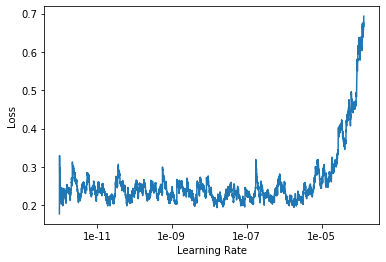

In [19]:
learner.lr_find(start_lr=1e-12, end_lr=10, num_it=10000)
learner.recorder.plot(skip_start=0)

In [20]:
lr2 = 1e-7
lr3 = 1e-6

In [21]:
learner.fit_one_cycle(cyc_len=epochs_unfrozen, 
                      max_lr=slice(lr2, lr3), 
                      callbacks=[SaveModelCallback(learner, 
                                                   every='epoch', 
                                                   monitor='accuracy_thresh', 
                                                   name='bestmodel_lr2=1e-7--lr3=1e-6')])

/opt/conda/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


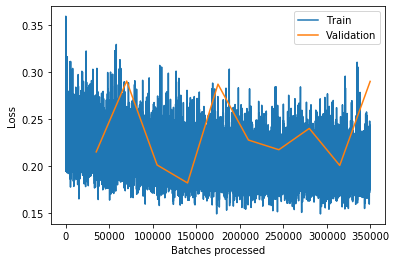

In [22]:
learner.recorder.plot_losses()

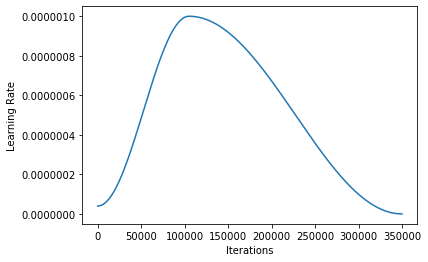

In [23]:
learner.recorder.plot_lr()

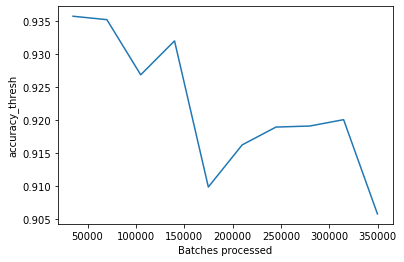

In [24]:
learner.recorder.plot_metrics()

In [15]:
nameComplete = f'{nameBase}-complete'

In [16]:
#learner.save(nameComplete)

In [17]:
learner.load(nameComplete)

Learner(data=ImageDataBunch;

Train: LabelList (220129 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
9,9,8,8;9,8;9
Path: /home/Deep_Learner/private/local;

Valid: LabelList (50281 items)
x: ImageList
Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512),Image (3, 512, 512)
y: MultiCategoryList
8;9,8;9,8;9,9,9
Path: /home/Deep_Learner/private/local;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=Tru

In [18]:
#learner.load('bestmodel_9')

# Prediction per case

In [19]:
def one_hot_encode(predicted_classes:list, all_classes:list):
    for c in predicted_classes:
        assert c in all_classes
    n = len(all_classes)
    res = np.zeros(n, int)
    for i, c in enumerate(all_classes):
        if c in predicted_classes:
            res[i] = 1 
    return res



def ensemble_predict(dict_arch_to_path_of_saved_model:typing.Dict[Callable, pathlib.Path], 
                     data:fastai.vision.data.ImageDataBunch,
                     ds_type:fastai.basic_data.DatasetType,
                     tta:bool, 
                     scale:float,
                     beta:float):
    """
    tta: Should test time augmentation be used?
    scale: if tta is True -> scaling factor for tta
    beta: if tta is True -> beta factor for tta
    check this out for more infos: https://docs.fast.ai/basic_train.html#Test-time-augmentation
    """
   
    print(f'{str([a.__name__ for a in dict_arch_to_path_of_saved_model.keys()])}_sz{sz}_ensembled')
    
    predsList = []
    for arch in dict_arch_to_path_of_saved_model.keys():
        learner = cnn_learner(data=data, base_arch=arch, pretrained=False)
        learner.load(dict_arch_to_path_of_saved_model[arch])
        if tta is True:
            preds = learner.TTA(beta=beta, scale=scale, ds_type=ds_type)
        else:
            preds = learner.get_preds(ds_type=ds_type)
            
        predsList.append(preds)
    
    preds_ensembled = predsList[0]
    for n, _ in enumerate(predsList):
        if n == 0:
            continue
        else:
            preds_ensembled[0] = preds_ensembled[0] + predsList[n][0]
    preds_ensembled[0] = preds_ensembled[0]/len(predsList)
    
    return preds_ensembled

def from_preds_to_dict_path_to_preds(preds, 
                                     imageDataBunch:fastai.vision.ImageDataBunch, 
                                     ds_type:fastai.basic_data.DatasetType,
                                     threshold:float):
    """
    preds: What fastai.vision.learner.get_preds or fastai.vision.learner.TTA return.
            two tensors: 1st: lists with raw predictions for each class of an image
                         2nd: lists with y_true
            form e.g. [tensor([[0.9672, 0.9211, 0.4560, 0.8185], 
                                [0.9498, 0.8600, 0.5852, 0.7206]]),
                         tensor([[0., 0., 0., 1.],
                                [0., 0., 1., 1.]])]
    threshold:  threshold to consider the predictions per tile to be correct or not
                                
    RETURN:
        key:path, value:tuple (fastai.core.MultiCategory, tensor preds one hot encoded, tensor with pure preds) 
        e.g. (MultiCategory 0, tensor([1., 0., 0., 0.]), tensor([0.9952, 0.0015, 0.0021, 0.0029]))
    path_to_pred = {}
    """
    #key:path, value:tuple (fastai.core.MultiCategory, tensor preds one hot encoded, tensor with pure preds) 
    #e.g. (MultiCategory 0, tensor([1., 0., 0., 0.]), tensor([0.9952, 0.0015, 0.0021, 0.0029]))
    path_to_pred = {}
    d = None
    if ds_type is DatasetType.Valid:
        d = imageDataBunch.valid_ds
    elif ds_type is DatasetType.Test:
        d = imageDataBunch.test_ds
    elif ds_type is DatasetType.Train:
        d = imageDataBunch.train_ds
    for path, pred in tqdm(zip(d.items, preds[0]), total = len(d.items)):
        multi_c = None
        pred_one_hot_encoded = (pred > threshold).float()
        pred_raw = pred
        path_to_pred[path] = multi_c, pred_one_hot_encoded, pred_raw
        
    return path_to_pred


def get_class_occurence_per_id(learner:fastai.vision.learner=None,
                               labelList:fastai.data_block.LabelList=None,
                               dict_arch_to_path_of_saved_model:typing.Dict[Callable, pathlib.Path]=None,
                               imageDataBunch:fastai.vision.data.ImageDataBunch=None,
                               ds_type:fastai.basic_data.DatasetType=None,
                               tta:bool=False,                                          
                               threshold = 0.5,                              
                               scale:float = 1.35,
                               beta: float = 0.4):
    """
    Option 1: Hand over a fastai.vision.learner and fastai.data_block.LabelList. No tta and no ensembling available
                for this option.
    Option 2: Hand over a fastai.vision.learner that was initalized with a fastai.vision.data.ImageDataBunch object.
    Option 3: Hand over dict where the keys are functions to create a model (e.g. torchvision.models.resnet50)
                and the values are paths to saved weights. Do this to use ensembling.
    
    Params:
        threshold:  threshold to consider the predictions per tile to be correct or not
        scale: only needed when tta is True; scale value for fastai's fastai.basic_train.Learner.TTA function
        beta: only needed when tta is True; beta value for fastai's fastai.basic_train.Learner.TTA function
    """
    
    if labelList is not None and ds_type is not None:
        raise ValueError('One of dataset or ds_type must be None')
    if labelList is not None and tta is True:
        raise ValueError('TTA is not available for a custom LabelList')
                
    #key:path, value:tuple (fastai.core.MultiCategory, tensor preds one hot encoded, tensor with pure preds) 
    #e.g. (MultiCategory 0, tensor([1., 0., 0., 0.]), tensor([0.9952, 0.0015, 0.0021, 0.0029]))
    path_to_pred = {}
    
    #Option 1
    if learner is not None and labelList is not None:
        for n, path in tqdm(enumerate(labelList.items), total=len(labelList.items)):
            pred = learner.predict(labelList[n][0], thresh=threshold)
            path_to_pred[path] = pred
    
    #Option 2
    elif learner is not None and labelList is None and  not dict_arch_to_path_of_saved_model and imageDataBunch is None:
        if tta is True:
            preds = learner.TTA(beta=beta, scale=scale, ds_type=ds_type)
        else:
            preds = learner.get_preds(ds_type=ds_type)
        path_to_pred = from_preds_to_dict_path_to_preds(preds, learner.data, ds_type, threshold)
                
    #Option 3
    elif dict_arch_to_path_of_saved_model and imageDataBunch is not None:
        preds = ensemble_predict(dict_arch_to_path_of_saved_model, imageDataBunch, ds_type, tta, scale, beta)
        path_to_pred = from_preds_to_dict_path_to_preds(preds, imageDataBunch, ds_type, threshold)                
               
    #key: id of a case; value: list with this syntax  
    #[<number of all tiles of one id>, 
    #[<number of occurence of predicted class1 over all tiles per id>, 
    #<number of occurence of predicted class2 over all tiles per id>, ..., 
    #<number of occurence of predicted classN over all tiles per id>],
    #y_true_one_hot_encoded]
    class_occurence_per_id = {}
    
    for path, pred in path_to_pred.items():   
        id = get_id_from_path(path)
        if id in class_occurence_per_id:
            v = class_occurence_per_id[id]
            v[0] = v[0] + 1
            v[1] = v[1] + pred[1]
            class_occurence_per_id[id] = v
        else:
            class_occurence_per_id[id] = [1, pred[1], one_hot_encode(label_func(path), lbs2num.values())]
            
    return class_occurence_per_id


def get_preds_threshold_per_id(thresholds_per_class:list, class_occurence_per_id:dict):
    """
    thresholds_per_class:  list with n = number_of_classes double values, e.g. four classes -> [0.5, 0.5, 0.5, 0.5] 
                            thresholds per class to consider the predictions per wsi to be correct or not
                            example: 100 tiles of one WSI, threshold for class 1 is 0.5, the wsi will get labeled with
                                        that class, if more than 50 tiles were labeled with that class by the classifier
                                
    RETURN:
            key: id of a case; 
            value: list with this syntax  
            [y_pred_th e.g. [True,False,False,False], 
            y_true e.g. [1,0,0,0]]
    """    
    result = {}
    for k in class_occurence_per_id.keys():
        y_pred_th = []
        for n, i in enumerate(class_occurence_per_id[k][1]):
            i = int(i)
            y_pred_th.append(i/class_occurence_per_id[k][0] > thresholds_per_class[n])
    
        result[k] = [y_pred_th, class_occurence_per_id[k][2]]
    return result

def get_accuracy_over_all_ids(number_of_ids, preds_threshold_per_id:dict, per_class:bool = True, number_of_classes = len(lbs2num)):
    if per_class is True:
        correctly_predicted = np.zeros(number_of_classes, dtype=np.int)
    else:
        correctly_predicted = 0
    for k in preds_threshold_per_id.keys():
        pred = preds_threshold_per_id[k][0]
        true = preds_threshold_per_id[k][1]
        for i in range(number_of_classes):
            if true[i] == pred[i]:
                if per_class is True:
                    correctly_predicted[i] = correctly_predicted[i] + 1
                else:
                    correctly_predicted = correctly_predicted + 1
    if per_class is True:                    
        correctly_predicted_percentage = {}
        for lb, num in zip(lbs2num.keys(), correctly_predicted):
            correctly_predicted_percentage[lb] = num/number_of_ids
    if per_class is False:
        correctly_predicted_percentage = correctly_predicted/number_of_ids

    return correctly_predicted_percentage

In [20]:
arches = {resnext101_32x8d:Path(MODEL_PATH/'6-resnext101_32x8d-size512-bs8-seed_73/bestmodel_15'),
          se_resnext101_32x4d:MODEL_PATH/'11-se_resnext101_32x4d-size512-bs10-epochs_head5-epochs_complete5-seed_73/11-se_resnext101_32x4d-size512-bs8-epochs_head5-epochs_complete5-seed_73-complete'}

ths = [0.5,0.5,0.5,0.5]

## val set

In [21]:
#copi_val = get_class_occurence_per_id(dict_arch_to_path_of_saved_model=arches,
#                                      imageDataBunch=data,
#                                      ds_type=DatasetType.Valid)
copi_val = get_class_occurence_per_id(learner=learner, ds_type=DatasetType.Valid, tta=False)

In [30]:
copi_val

{'1314-12': [4309,
  tensor([2.4000e+01, 3.0000e+00, 4.2640e+03, 3.9480e+03]),
  array([0, 0, 1, 1])],
 '1016-15': [2874, tensor([   5.,    0., 2801., 2683.]), array([0, 0, 1, 1])],
 '425-15': [1339, tensor([   5.,    7., 1328., 1323.]), array([0, 0, 1, 1])],
 '203-16': [2875, tensor([  71.,    0.,   59., 2507.]), array([0, 0, 0, 1])],
 '1744-12': [834, tensor([ 28.,   6., 180., 740.]), array([0, 0, 0, 1])],
 '1111-13': [970, tensor([ 23.,   0., 921., 712.]), array([0, 0, 1, 1])],
 '208-16': [2318, tensor([ 142.,    0., 2116.,  563.]), array([0, 0, 1, 0])],
 '1523-14': [5653, tensor([  11.,    9., 5624., 3506.]), array([0, 0, 1, 1])],
 '518-14': [929, tensor([ 45.,   1., 866.,  94.]), array([0, 0, 1, 1])],
 '1559-13': [1044, tensor([121.,  18.,  74., 811.]), array([0, 0, 0, 1])],
 '2206-15': [1636, tensor([  41.,    0.,  131., 1400.]), array([0, 0, 0, 1])],
 '105-15': [3533, tensor([  33.,    5., 3451., 2840.]), array([0, 0, 1, 1])],
 '1078-14': [984, tensor([ 26.,  34., 112., 900.]), 

### thresholded accuracy per class

In [76]:
preds_th_val = get_preds_threshold_per_id(ths, copi_val)

In [ ]:
accuracy_per_class_val = get_accuracy_over_all_ids(len(preds_th_val), preds_th_val)

### roc_curves and probability histograms

In [156]:
class_names = ['acth', 'silent', 'lh', 'fsh']
class_numbers = [0,1,2,3]

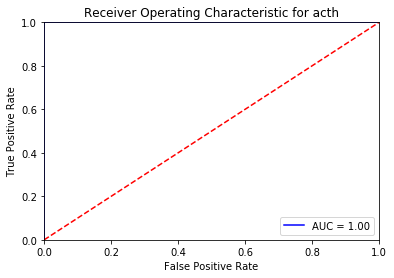

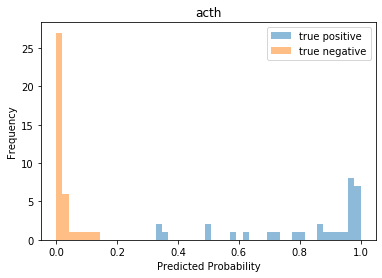

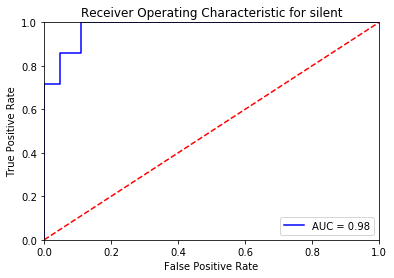

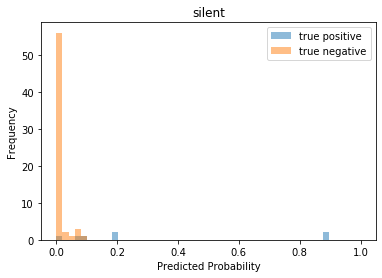

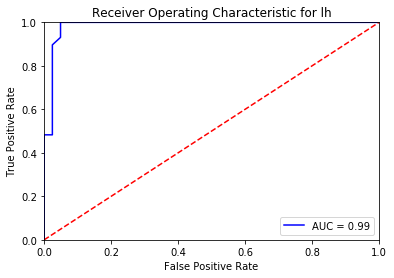

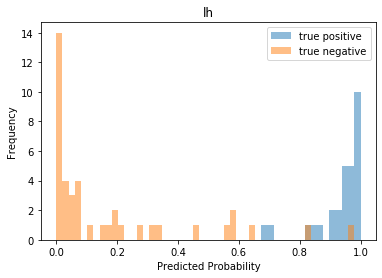

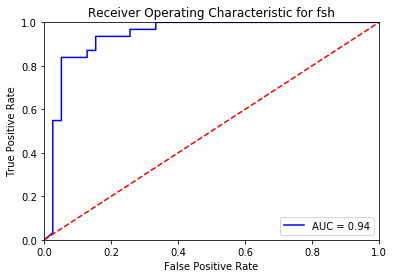

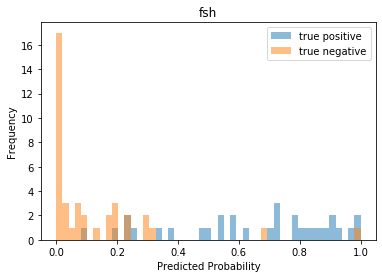

In [159]:
for class_name, class_number in zip(class_names, class_numbers):
    ###
    # roc_curve
    ###
    y_preds = []
    y_true = []
    for key, value in tqdm(copi_val.items()):
        #calculate prediction score for {class_name}
        n_tiles_all = value[0]
        n_tiles_class = value[1][class_number]
        percentage = n_tiles_class/n_tiles_all
        y_preds.append(percentage)
        
        #true label for {class_name}
        y_true.append(value[2][class_number])
        
    
    fpr, tpr, threshold = roc_curve(y_true, y_preds, pos_label=1)
    
    roc_auc = auc(fpr, tpr)
    
    plt.title(f'Receiver Operating Characteristic for {class_name}')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
    
    ###
    # histogram
    ###
    #predicted probabilities for {class_name} for WSIs, that were really {class_name}
    probs_true_positive = []
    #predicted probabilities for {class_name} for WSIs, that were really not {class_name}
    probs_true_negative =[]
    for key, value in tqdm(copi_val.items()):
        #calculate prediction score for {class_name}
        n_tiles_all = value[0]
        n_tiles_class = value[1][class_number]
        percentage = n_tiles_class/n_tiles_all
        if value[2][class_number] == 1:
            probs_true_positive.append(percentage)
        else:
            probs_true_negative.append(percentage)
    
    from matplotlib import pyplot
    
    bins = np.linspace(0, 1, 50)
    
    pyplot.hist(probs_true_positive, bins, alpha=0.5, label='true positive')
    pyplot.hist(probs_true_negative, bins, alpha=0.5, label='true negative')
    pyplot.legend(loc='upper right')
    pyplot.title(label=class_name)
    pyplot.ylabel('Frequency')
    pyplot.xlabel('Predicted Probability')
    pyplot.show()

### roc_curve gonadotropic vs corticotropic

In [92]:
ys_preds_corticotropic = []
ys_preds_gonadotropic = []
ys_true_corticotropic = []
for key, value in tqdm(copi_val.items()):
    #calculate prediction score for corticotropic and gonadotropic 
    n_tiles_all = value[0]
    n_acth = value[1][0]
    n_silent = value[1][1]
    n_lh = value[1][2]
    n_fsh = value[1][3]
    n_corticotropic = int(max(n_acth, n_silent))
    n_gonadotropic = int(max(n_lh, n_fsh))
    #n_corticotropic = int(n_acth + n_silent)
    #n_gonadotropic = int(n_lh + n_fsh)
    percentage_corticotropic = n_corticotropic/n_tiles_all
    percentage_gonadotropic = n_gonadotropic/n_tiles_all
    #print(f'{key}: pcort: {percentage_corticotropic} + pgon: {percentage_gonadotropic} = {percentage_corticotropic + percentage_gonadotropic}')
    ys_preds_corticotropic.append(percentage_corticotropic)
    ys_preds_gonadotropic.append(percentage_gonadotropic)
    
    
    #calculate true label for corticotropic
    y_true_corticotropic = max(value[2][0], value[2][1])
    ys_true_corticotropic.append(y_true_corticotropic)
    
    #print(f'{key}: {percentage_corticotropic}  {y_true_corticotropic}')

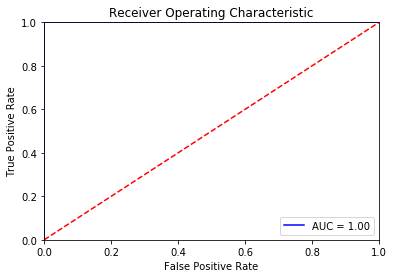

In [93]:
fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label=1)

roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## test set

### seed 73

In [ ]:
#copi_test = get_class_occurence_per_id(dict_arch_to_path_of_saved_model=arches,
#                                      imageDataBunch=data,
#                                      ds_type=DatasetType.Test)
copi_test = get_class_occurence_per_id(learner=learner, ds_type=DatasetType.Test, tta=False)
preds_th_test = get_preds_threshold_per_id(ths, copi_test)
accuracy_per_class_test = get_accuracy_over_all_ids(len(preds_th_test), preds_th_test)

In [ ]:
accuracy_per_class_test

### seed 42

# Interpreter

In [ ]:
interp = ClassificationInterpretation.from_learner(learner)

In [ ]:
def custom_confusion_matrix(self, slice_size:int=1):
        "Confusion matrix as an `np.ndarray`."
        x=torch.arange(0,self.data.c)
        if slice_size is None: cm = ((self.pred_class==x[:,None]) & (self.y_true==x[:,None,None])).sum(2)
        else:
            cm = torch.zeros(self.data.c, self.data.c, dtype=x.dtype)
            for i in range(0, self.y_true.shape[0], slice_size):
                #cm_slice = ((self.pred_class[i:i+slice_size]==x[:,None])
                            #& (self.y_true[i:i+slice_size]==x[:,None,None])).sum(2)
                cm_slice = ((self.pred_class[i:i+slice_size]==x[:,None])
                            & (self.y_true[i:i+slice_size]==(x[:,None,None]).float())).sum(2)
                torch.add(cm, cm_slice, out=cm)
        return to_np(cm)
    
fastai.train.ClassificationInterpretation.confusion_matrix = custom_confusion_matrix

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
interp.plot_top_losses(10)